<a href="https://colab.research.google.com/github/VLCHS/FCNN/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb==0.18.7
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 14.8 MB/s eta 0:00:00


In [2]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [3]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [5]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

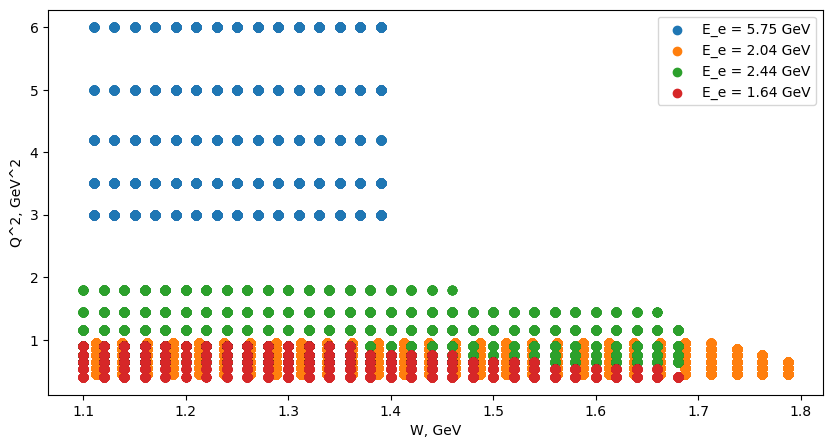

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [7]:
# Initialize wandb
run = wandb.init(project="FCNN for ep->ep_pi0, unified topology")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.sqrt(torch.mean((x - y)**2))
        return criterion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 20,
    'test_size': 0.1,
    'batch_size': 1024,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 50,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            augment_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(augment_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_df = pd.concat([augment_df, aug_df], ignore_index=True)
            train_label_data = augment_df["dsigma_dOmega"]
            train_feature_data = augment_df.loc[:, ~augment_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [9]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2024-12-09 18:49:09,936 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2024-12-09 18:49:09,953 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-09 18:49:09,960 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-09 18:49:09,973 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2024-12-09 18:49:11,131 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2024-12-09 18:49:11,289 : INFO : Training is starting
2024-12-09 18:50:02,830 : INFO : epoch: 0; val_loss: 3.4869704246520996
2024-

INFO: Metric val_loss improved. New best score: 3.487


2024-12-09 18:50:02,879 : INFO : Metric val_loss improved. New best score: 3.487
2024-12-09 18:50:03,572 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=3.48697-epoch=00.ckpt
2024-12-09 18:50:50,883 : INFO : epoch: 1; val_loss: 3.14347767829895
2024-12-09 18:50:50,897 : INFO : epoch: 1; train_loss: 2.9987051486968994


INFO: Metric val_loss improved by 0.343 >= min_delta = 1e-05. New best score: 3.143


2024-12-09 18:50:50,935 : INFO : Metric val_loss improved by 0.343 >= min_delta = 1e-05. New best score: 3.143
2024-12-09 18:50:51,152 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=3.14348-epoch=01.ckpt
2024-12-09 18:51:44,519 : INFO : epoch: 2; val_loss: 2.8316261768341064
2024-12-09 18:51:44,534 : INFO : epoch: 2; train_loss: 2.860851764678955


INFO: Metric val_loss improved by 0.312 >= min_delta = 1e-05. New best score: 2.832


2024-12-09 18:51:44,581 : INFO : Metric val_loss improved by 0.312 >= min_delta = 1e-05. New best score: 2.832
2024-12-09 18:51:44,909 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=2.83163-epoch=02.ckpt
2024-12-09 18:52:34,797 : INFO : epoch: 3; val_loss: 2.3176777362823486
2024-12-09 18:52:34,810 : INFO : epoch: 3; train_loss: 2.7712299823760986


INFO: Metric val_loss improved by 0.514 >= min_delta = 1e-05. New best score: 2.318


2024-12-09 18:52:34,833 : INFO : Metric val_loss improved by 0.514 >= min_delta = 1e-05. New best score: 2.318
2024-12-09 18:52:35,176 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=2.31768-epoch=03.ckpt
2024-12-09 18:53:24,294 : INFO : epoch: 4; val_loss: 1.5136381387710571
2024-12-09 18:53:24,305 : INFO : epoch: 4; train_loss: 2.130340814590454


INFO: Metric val_loss improved by 0.804 >= min_delta = 1e-05. New best score: 1.514


2024-12-09 18:53:24,326 : INFO : Metric val_loss improved by 0.804 >= min_delta = 1e-05. New best score: 1.514
2024-12-09 18:53:24,560 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.51364-epoch=04.ckpt
2024-12-09 18:54:13,444 : INFO : epoch: 5; val_loss: 1.4591237306594849
2024-12-09 18:54:13,455 : INFO : epoch: 5; train_loss: 1.823041319847107


INFO: Metric val_loss improved by 0.055 >= min_delta = 1e-05. New best score: 1.459


2024-12-09 18:54:13,476 : INFO : Metric val_loss improved by 0.055 >= min_delta = 1e-05. New best score: 1.459
2024-12-09 18:54:13,706 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.45912-epoch=05.ckpt
2024-12-09 18:55:03,221 : INFO : epoch: 6; val_loss: 1.5976818799972534
2024-12-09 18:55:03,236 : INFO : epoch: 6; train_loss: 1.7564038038253784
2024-12-09 18:55:03,503 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.59768-epoch=06.ckpt
2024-12-09 18:55:52,650 : INFO : epoch: 7; val_loss: 1.6728383302688599
2024-12-09 18:55:52,662 : INFO : epoch: 7; train_loss: 1.5863443613052368
2024-12-09 18:56:43,950 : INFO : epoch: 8; val_loss: 1.4055286645889282
2024-12-09 18:56:43,962 : INFO : epoch: 8; train_loss: 1.7489557266235352


INFO: Metric val_loss improved by 0.054 >= min_delta = 1e-05. New best score: 1.406


2024-12-09 18:56:43,988 : INFO : Metric val_loss improved by 0.054 >= min_delta = 1e-05. New best score: 1.406
2024-12-09 18:56:44,312 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.40553-epoch=08.ckpt
2024-12-09 18:57:38,118 : INFO : epoch: 9; val_loss: 1.344494104385376
2024-12-09 18:57:38,129 : INFO : epoch: 9; train_loss: 1.5025269985198975


INFO: Metric val_loss improved by 0.061 >= min_delta = 1e-05. New best score: 1.344


2024-12-09 18:57:38,154 : INFO : Metric val_loss improved by 0.061 >= min_delta = 1e-05. New best score: 1.344
2024-12-09 18:57:38,423 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.34449-epoch=09.ckpt
2024-12-09 18:58:34,020 : INFO : epoch: 10; val_loss: 1.3698371648788452
2024-12-09 18:58:34,037 : INFO : epoch: 10; train_loss: 1.5935438871383667
2024-12-09 18:58:34,451 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.36984-epoch=10.ckpt
2024-12-09 18:59:29,504 : INFO : epoch: 11; val_loss: 1.2844775915145874
2024-12-09 18:59:29,516 : INFO : epoch: 11; train_loss: 1.4668467044830322


INFO: Metric val_loss improved by 0.060 >= min_delta = 1e-05. New best score: 1.284


2024-12-09 18:59:29,539 : INFO : Metric val_loss improved by 0.060 >= min_delta = 1e-05. New best score: 1.284
2024-12-09 18:59:29,756 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.28448-epoch=11.ckpt
2024-12-09 19:00:23,052 : INFO : epoch: 12; val_loss: 2.1839277744293213
2024-12-09 19:00:23,062 : INFO : epoch: 12; train_loss: 1.477447509765625
2024-12-09 19:01:22,586 : INFO : epoch: 13; val_loss: 1.5633182525634766
2024-12-09 19:01:22,601 : INFO : epoch: 13; train_loss: 1.6125808954238892
2024-12-09 19:02:17,750 : INFO : epoch: 14; val_loss: 1.5330032110214233
2024-12-09 19:02:17,764 : INFO : epoch: 14; train_loss: 1.4603221416473389
2024-12-09 19:03:10,798 : INFO : epoch: 15; val_loss: 1.244230031967163
2024-12-09 19:03:10,810 : INFO : epoch: 15; train_loss: 1.4294403791427612


INFO: Metric val_loss improved by 0.040 >= min_delta = 1e-05. New best score: 1.244


2024-12-09 19:03:10,832 : INFO : Metric val_loss improved by 0.040 >= min_delta = 1e-05. New best score: 1.244
2024-12-09 19:03:11,317 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.24423-epoch=15.ckpt
2024-12-09 19:04:07,710 : INFO : epoch: 16; val_loss: 1.3443957567214966
2024-12-09 19:04:07,720 : INFO : epoch: 16; train_loss: 1.4091144800186157
2024-12-09 19:04:07,905 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.34440-epoch=16.ckpt
2024-12-09 19:05:01,694 : INFO : epoch: 17; val_loss: 1.4673223495483398
2024-12-09 19:05:01,705 : INFO : epoch: 17; train_loss: 1.3945024013519287
2024-12-09 19:05:55,164 : INFO : epoch: 18; val_loss: 1.390624761581421
2024-12-09 19:05:55,176 : INFO : epoch: 18; train_loss: 1.3904348611831665
2024-12-09 19:06:50,510 : INFO : epoch: 19; val_loss: 1.334884762763977
2024-12-09 19:06

INFO: Metric val_loss improved by 0.083 >= min_delta = 1e-05. New best score: 1.161


2024-12-09 19:07:45,846 : INFO : Metric val_loss improved by 0.083 >= min_delta = 1e-05. New best score: 1.161
2024-12-09 19:07:46,050 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.16100-epoch=20.ckpt
2024-12-09 19:08:40,301 : INFO : epoch: 21; val_loss: 1.2622990608215332
2024-12-09 19:08:40,313 : INFO : epoch: 21; train_loss: 1.3030200004577637
2024-12-09 19:08:40,536 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.26230-epoch=21.ckpt
2024-12-09 19:09:35,290 : INFO : epoch: 22; val_loss: 1.152640461921692
2024-12-09 19:09:35,312 : INFO : epoch: 22; train_loss: 1.2992539405822754


INFO: Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 1.153


2024-12-09 19:09:35,341 : INFO : Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 1.153
2024-12-09 19:09:35,605 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.15264-epoch=22.ckpt
2024-12-09 19:10:29,986 : INFO : epoch: 23; val_loss: 1.1433466672897339
2024-12-09 19:10:29,998 : INFO : epoch: 23; train_loss: 1.3018431663513184


INFO: Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 1.143


2024-12-09 19:10:30,023 : INFO : Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 1.143
2024-12-09 19:10:30,286 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.14335-epoch=23.ckpt
2024-12-09 19:11:26,831 : INFO : epoch: 24; val_loss: 1.2720104455947876
2024-12-09 19:11:26,845 : INFO : epoch: 24; train_loss: 1.3106799125671387
2024-12-09 19:12:20,877 : INFO : epoch: 25; val_loss: 1.193005084991455
2024-12-09 19:12:20,892 : INFO : epoch: 25; train_loss: 1.2874165773391724
2024-12-09 19:13:16,366 : INFO : epoch: 26; val_loss: 1.1747533082962036
2024-12-09 19:13:16,380 : INFO : epoch: 26; train_loss: 1.281653642654419
2024-12-09 19:14:09,199 : INFO : epoch: 27; val_loss: 1.1538681983947754
2024-12-09 19:14:09,212 : INFO : epoch: 27; train_loss: 1.289735198020935
2024-12-09 19:14:09,471 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cher

INFO: Metric val_loss improved by 0.028 >= min_delta = 1e-05. New best score: 1.115


2024-12-09 19:23:15,091 : INFO : Metric val_loss improved by 0.028 >= min_delta = 1e-05. New best score: 1.115
2024-12-09 19:23:15,385 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.11524-epoch=37.ckpt
2024-12-09 19:24:10,363 : INFO : epoch: 38; val_loss: 1.1345596313476562
2024-12-09 19:24:10,380 : INFO : epoch: 38; train_loss: 1.220557689666748
2024-12-09 19:24:10,635 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.13456-epoch=38.ckpt
2024-12-09 19:25:05,119 : INFO : epoch: 39; val_loss: 1.1286309957504272
2024-12-09 19:25:05,129 : INFO : epoch: 39; train_loss: 1.2329118251800537
2024-12-09 19:25:05,390 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.12863-epoch=39.ckpt
2024-12-09 19:25:59,377 : INFO : epoch: 40; val_loss: 1.1

INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.110


2024-12-09 19:29:36,542 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.110
2024-12-09 19:29:36,834 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.11003-epoch=44.ckpt
2024-12-09 19:30:31,498 : INFO : epoch: 45; val_loss: 1.127084493637085
2024-12-09 19:30:31,513 : INFO : epoch: 45; train_loss: 1.2193799018859863
2024-12-09 19:30:31,684 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.12708-epoch=45.ckpt
2024-12-09 19:31:25,174 : INFO : epoch: 46; val_loss: 1.1437965631484985
2024-12-09 19:31:25,184 : INFO : epoch: 46; train_loss: 1.2288671731948853
2024-12-09 19:32:19,201 : INFO : epoch: 47; val_loss: 1.2093627452850342
2024-12-09 19:32:19,216 : INFO : epoch: 47; train_loss: 1.2210434675216675
2024-12-09 19:33:14,625 : INFO : epoch: 48; val_loss: 1.1556639671325684
2024-12-09 19:3

INFO: Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 1.098


2024-12-09 19:37:45,744 : INFO : Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 1.098
2024-12-09 19:37:45,972 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.09840-epoch=53.ckpt
2024-12-09 19:38:40,718 : INFO : epoch: 54; val_loss: 1.119605302810669
2024-12-09 19:38:40,730 : INFO : epoch: 54; train_loss: 1.2217862606048584
2024-12-09 19:39:36,505 : INFO : epoch: 55; val_loss: 1.1318929195404053
2024-12-09 19:39:36,521 : INFO : epoch: 55; train_loss: 1.2046979665756226
2024-12-09 19:40:31,413 : INFO : epoch: 56; val_loss: 1.1239187717437744
2024-12-09 19:40:31,426 : INFO : epoch: 56; train_loss: 1.214207649230957
2024-12-09 19:41:24,974 : INFO : epoch: 57; val_loss: 1.091836929321289
2024-12-09 19:41:24,990 : INFO : epoch: 57; train_loss: 1.201936960220337


INFO: Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 1.092


2024-12-09 19:41:25,012 : INFO : Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 1.092
2024-12-09 19:41:25,242 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.09184-epoch=57.ckpt
2024-12-09 19:42:20,310 : INFO : epoch: 58; val_loss: 1.0815342664718628
2024-12-09 19:42:20,326 : INFO : epoch: 58; train_loss: 1.1908323764801025


INFO: Metric val_loss improved by 0.010 >= min_delta = 1e-05. New best score: 1.082


2024-12-09 19:42:20,354 : INFO : Metric val_loss improved by 0.010 >= min_delta = 1e-05. New best score: 1.082
2024-12-09 19:42:20,568 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.08153-epoch=58.ckpt
2024-12-09 19:43:15,412 : INFO : epoch: 59; val_loss: 1.0902637243270874
2024-12-09 19:43:15,426 : INFO : epoch: 59; train_loss: 1.1905211210250854
2024-12-09 19:43:15,628 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.09026-epoch=59.ckpt
2024-12-09 19:44:09,662 : INFO : epoch: 60; val_loss: 1.1023262739181519
2024-12-09 19:44:09,676 : INFO : epoch: 60; train_loss: 1.1869851350784302
2024-12-09 19:45:04,028 : INFO : epoch: 61; val_loss: 1.086463451385498
2024-12-09 19:45:04,043 : INFO : epoch: 61; train_loss: 1.1972172260284424
2024-12-09 19:45:04,271 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_p

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.081


2024-12-09 20:00:36,317 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.081
2024-12-09 20:00:36,600 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.08059-epoch=78.ckpt
2024-12-09 20:01:31,789 : INFO : epoch: 79; val_loss: 1.0803074836730957
2024-12-09 20:01:31,803 : INFO : epoch: 79; train_loss: 1.1672853231430054


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.080


2024-12-09 20:01:31,825 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.080
2024-12-09 20:01:32,095 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.08031-epoch=79.ckpt
2024-12-09 20:02:29,210 : INFO : epoch: 80; val_loss: 1.0863780975341797
2024-12-09 20:02:29,224 : INFO : epoch: 80; train_loss: 1.1715712547302246
2024-12-09 20:03:23,638 : INFO : epoch: 81; val_loss: 1.0814303159713745
2024-12-09 20:03:23,648 : INFO : epoch: 81; train_loss: 1.1724910736083984
2024-12-09 20:03:24,090 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.08143-epoch=81.ckpt
2024-12-09 20:04:18,743 : INFO : epoch: 82; val_loss: 1.0776265859603882
2024-12-09 20:04:18,759 : INFO : epoch: 82; train_loss: 1.1661648750305176


INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.078


2024-12-09 20:04:18,783 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.078
2024-12-09 20:04:19,220 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.07763-epoch=82.ckpt
2024-12-09 20:05:15,705 : INFO : epoch: 83; val_loss: 1.0836821794509888
2024-12-09 20:05:15,719 : INFO : epoch: 83; train_loss: 1.158036231994629
2024-12-09 20:06:10,047 : INFO : epoch: 84; val_loss: 1.0820262432098389
2024-12-09 20:06:10,059 : INFO : epoch: 84; train_loss: 1.1677402257919312
2024-12-09 20:07:04,586 : INFO : epoch: 85; val_loss: 1.082403540611267
2024-12-09 20:07:04,602 : INFO : epoch: 85; train_loss: 1.1831707954406738
2024-12-09 20:08:00,976 : INFO : epoch: 86; val_loss: 1.0829576253890991
2024-12-09 20:08:00,990 : INFO : epoch: 86; train_loss: 1.16685950756073
2024-12-09 20:08:55,090 : INFO : epoch: 87; val_loss: 1.0923757553100586
2024-12-09 20:08:55,103 : INFO : epoch: 87; train

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.077


2024-12-09 20:13:28,914 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.077
2024-12-09 20:13:29,318 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.07679-epoch=92.ckpt
2024-12-09 20:14:23,697 : INFO : epoch: 93; val_loss: 1.0774303674697876
2024-12-09 20:14:23,709 : INFO : epoch: 93; train_loss: 1.1646883487701416
2024-12-09 20:14:23,982 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.07743-epoch=93.ckpt
2024-12-09 20:15:17,621 : INFO : epoch: 94; val_loss: 1.0789661407470703
2024-12-09 20:15:17,634 : INFO : epoch: 94; train_loss: 1.1612493991851807
2024-12-09 20:16:12,859 : INFO : epoch: 95; val_loss: 1.0853095054626465
2024-12-09 20:16:12,875 : INFO : epoch: 95; train_loss: 1.154792070388794
2024-12-09 20:17:07,873 : INFO : epoch: 96; val_loss: 1.0824791193008423
2024-12-09 20:1

INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.074


2024-12-09 20:22:39,112 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.074
2024-12-09 20:22:39,432 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.07399-epoch=102.ckpt
2024-12-09 20:23:33,802 : INFO : epoch: 103; val_loss: 1.083870530128479
2024-12-09 20:23:33,813 : INFO : epoch: 103; train_loss: 1.160053014755249
2024-12-09 20:24:28,112 : INFO : epoch: 104; val_loss: 1.082904577255249
2024-12-09 20:24:28,123 : INFO : epoch: 104; train_loss: 1.160725474357605
2024-12-09 20:25:24,299 : INFO : epoch: 105; val_loss: 1.0772148370742798
2024-12-09 20:25:24,309 : INFO : epoch: 105; train_loss: 1.1614048480987549
2024-12-09 20:25:24,532 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/vibrant-cherry-7/checkpoints/exp_name=0val_loss=1.07721-epoch=105.ckpt
2024-12-09 20:26:19,064 : INFO : epoch: 106; val_loss: 1.0747413635253906
2024-12-0

INFO: Monitored metric val_loss did not improve in the last 50 records. Best score: 1.074. Signaling Trainer to stop.


2024-12-09 21:08:57,174 : INFO : Monitored metric val_loss did not improve in the last 50 records. Best score: 1.074. Signaling Trainer to stop.
2024-12-09 21:08:57,198 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [10]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [11]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:07<00:00, 20.08it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.34212797007547757' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.055274168529454444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2024-12-09 21:22:08,776 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-09 21:22:08,783 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-09 21:22:08,790 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-09 21:22:08,796 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
2024-12-09 21:22:08,803 : DEBUG : findfont: score(FontEntry

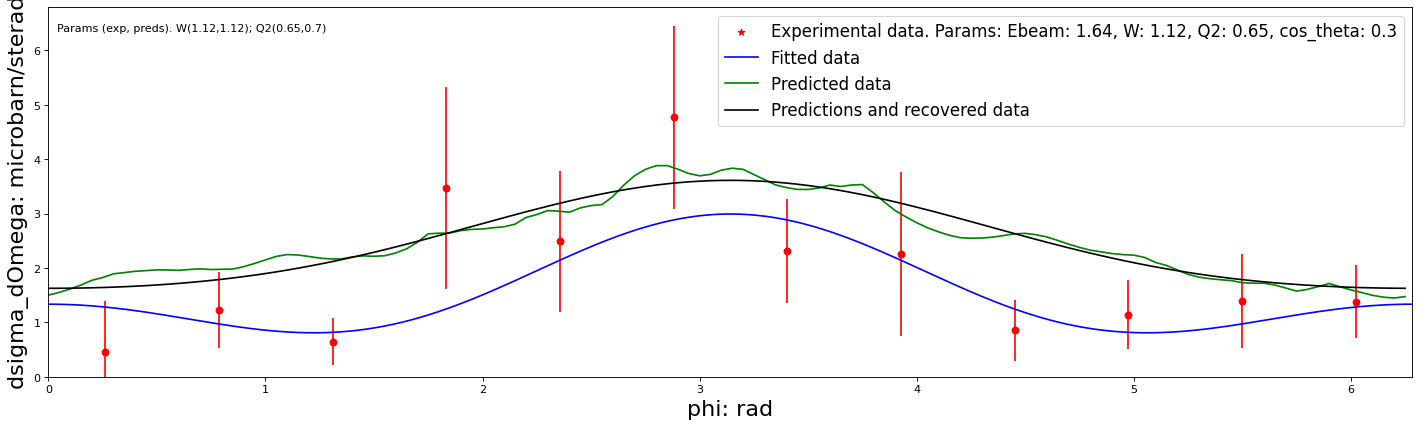

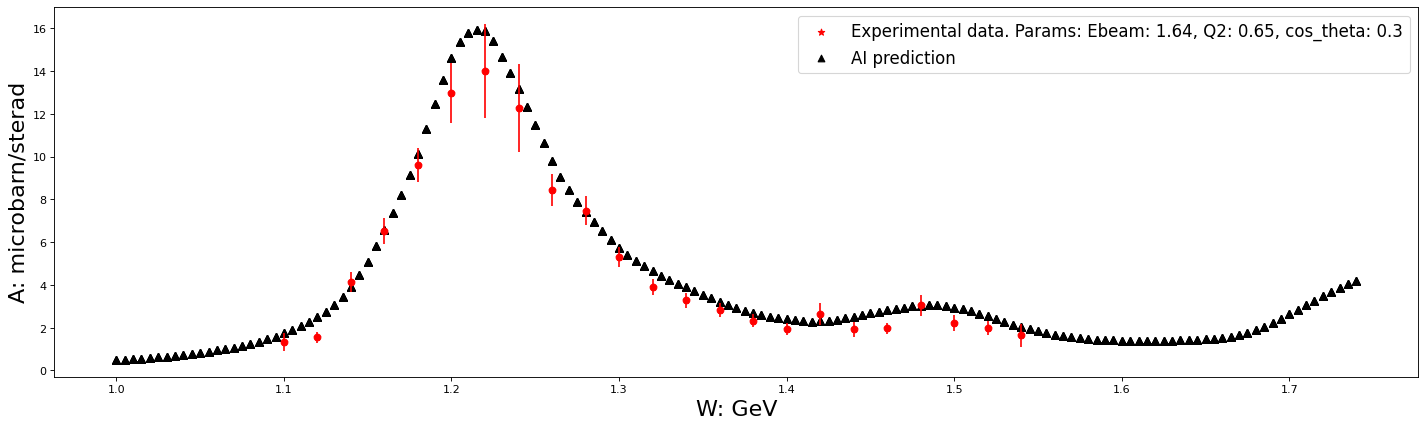

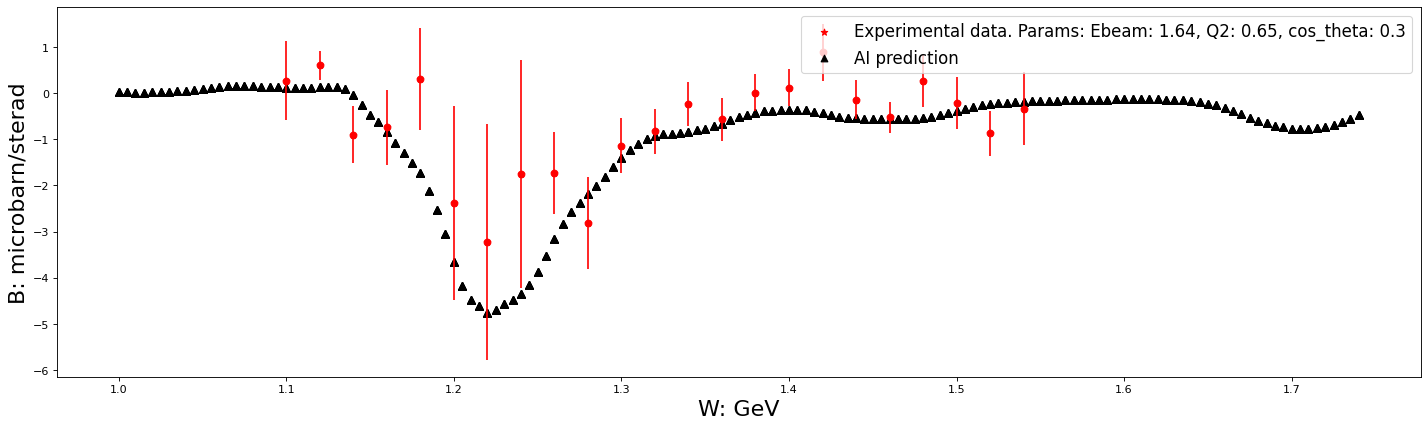

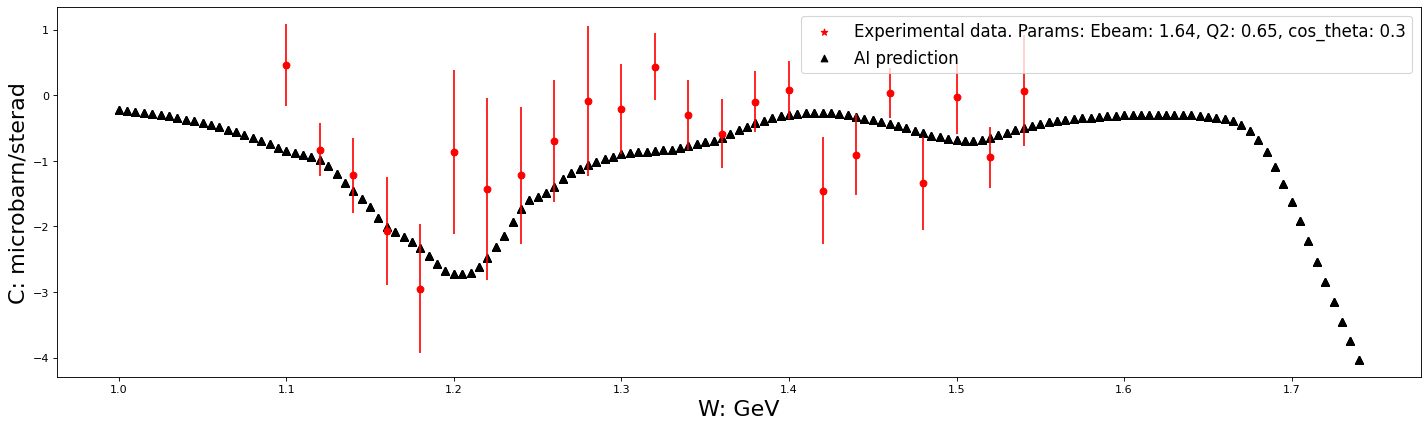

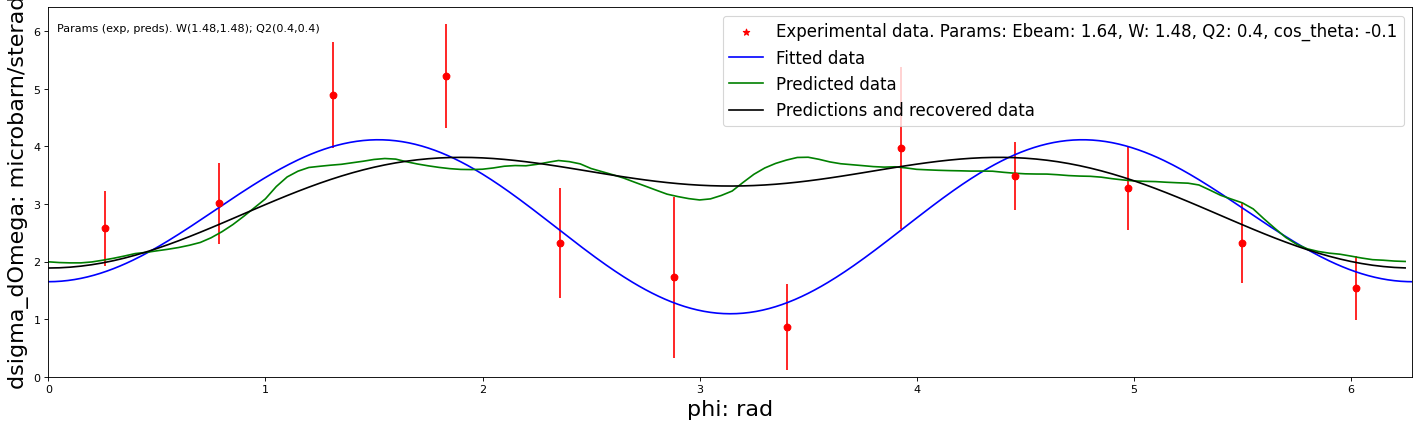

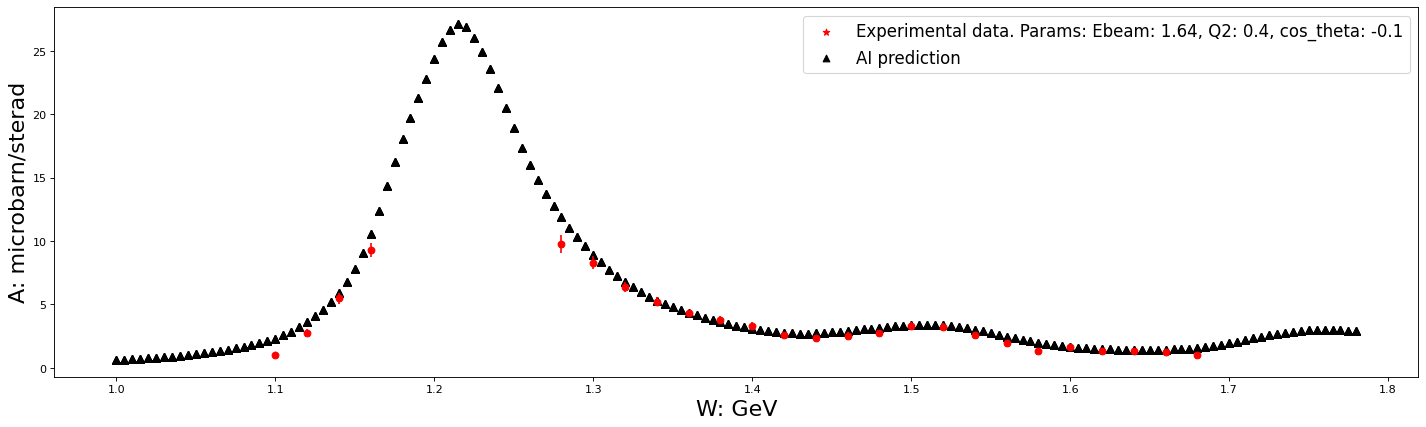

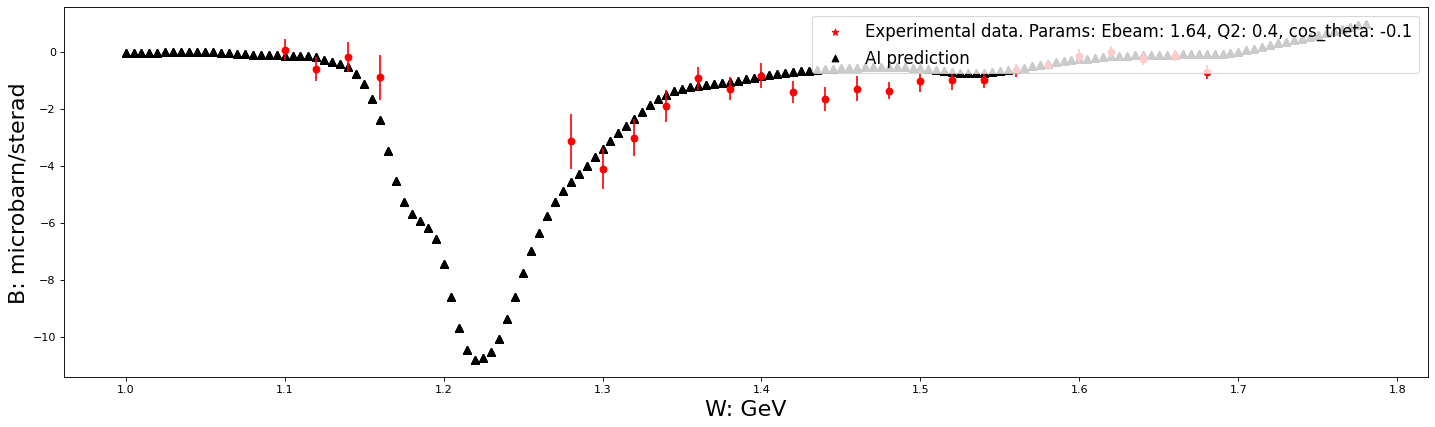

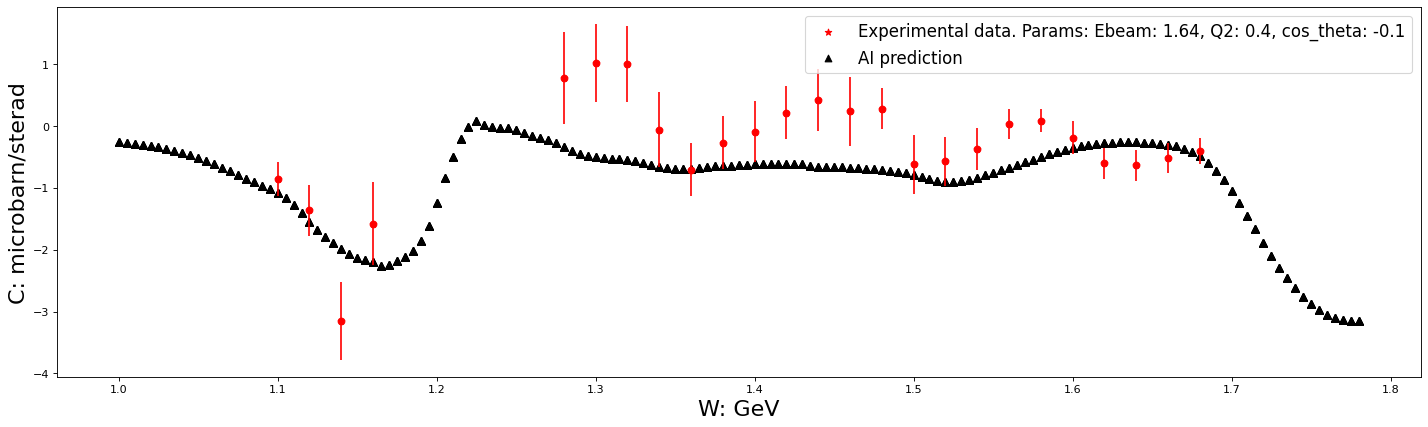

100%|██████████| 157/157 [00:07<00:00, 20.14it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2942164318320661' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01086176167732479' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inpu

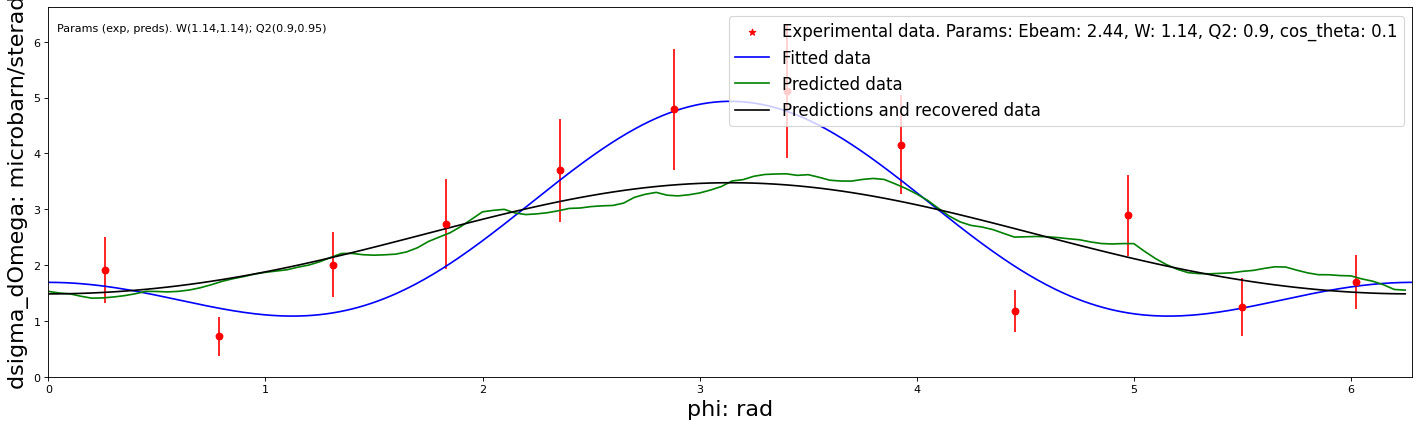

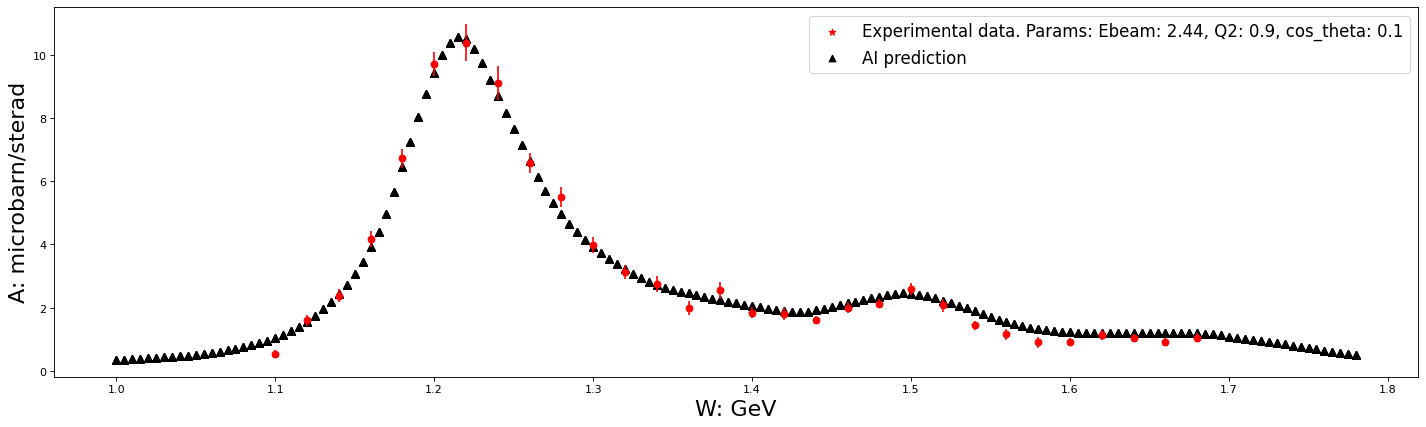

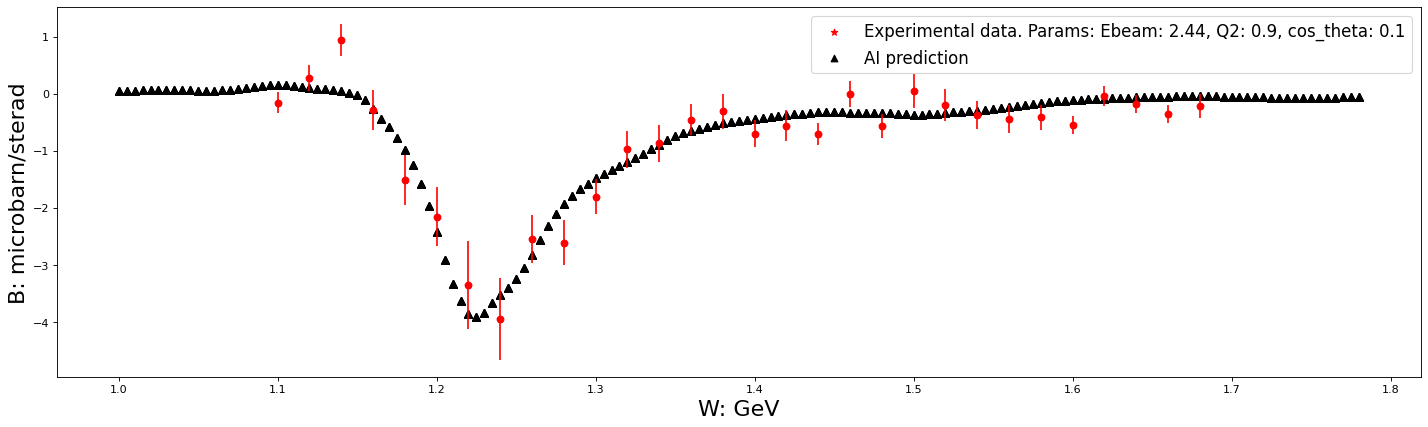

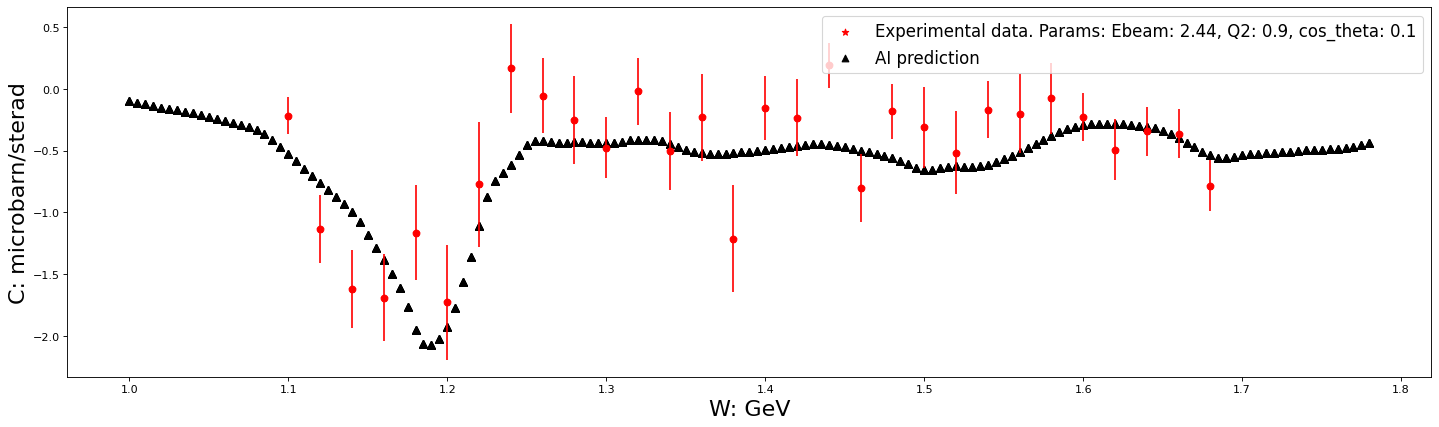

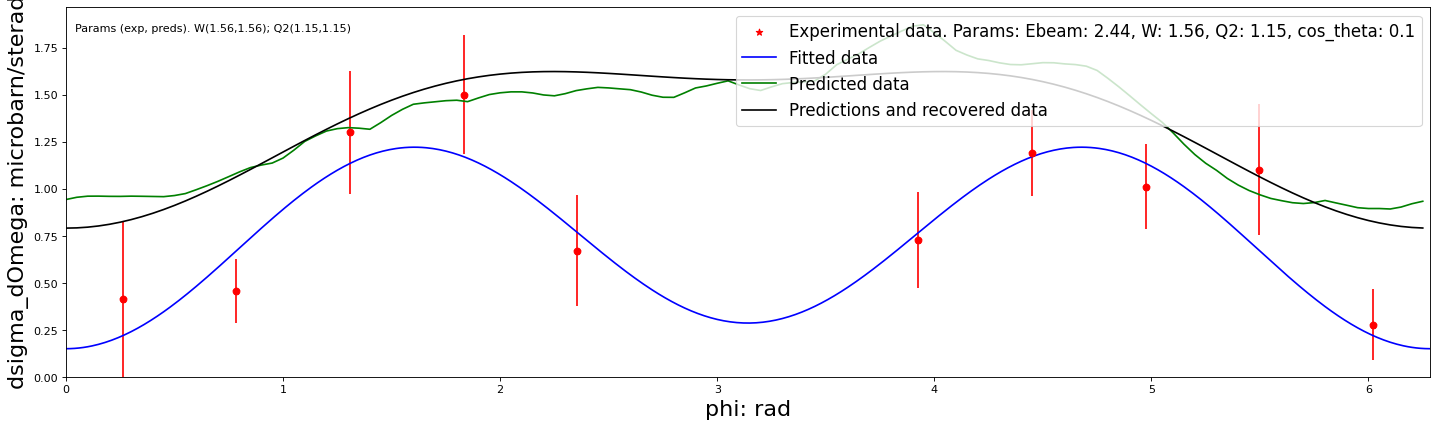

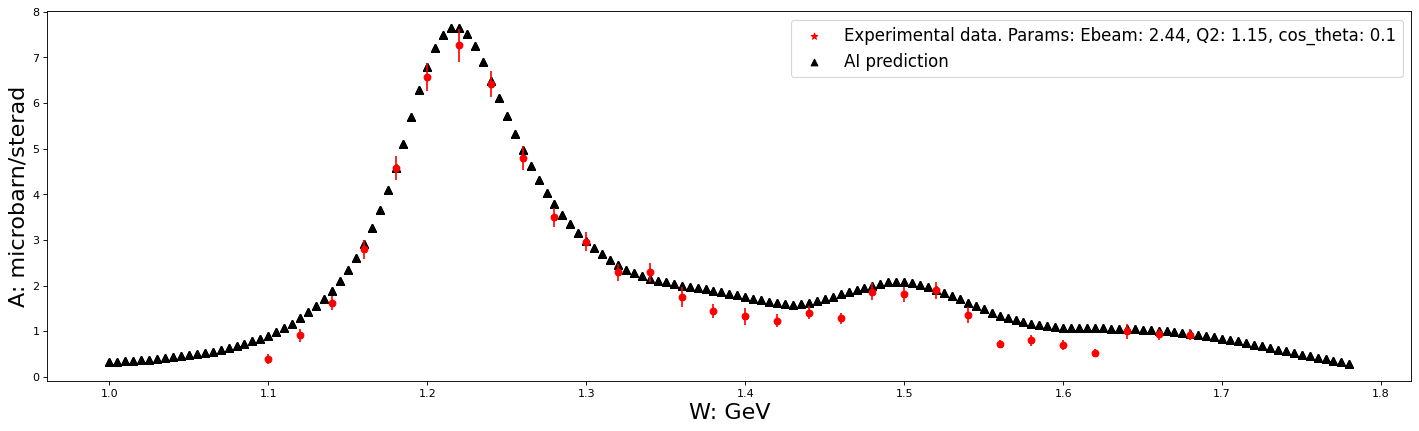

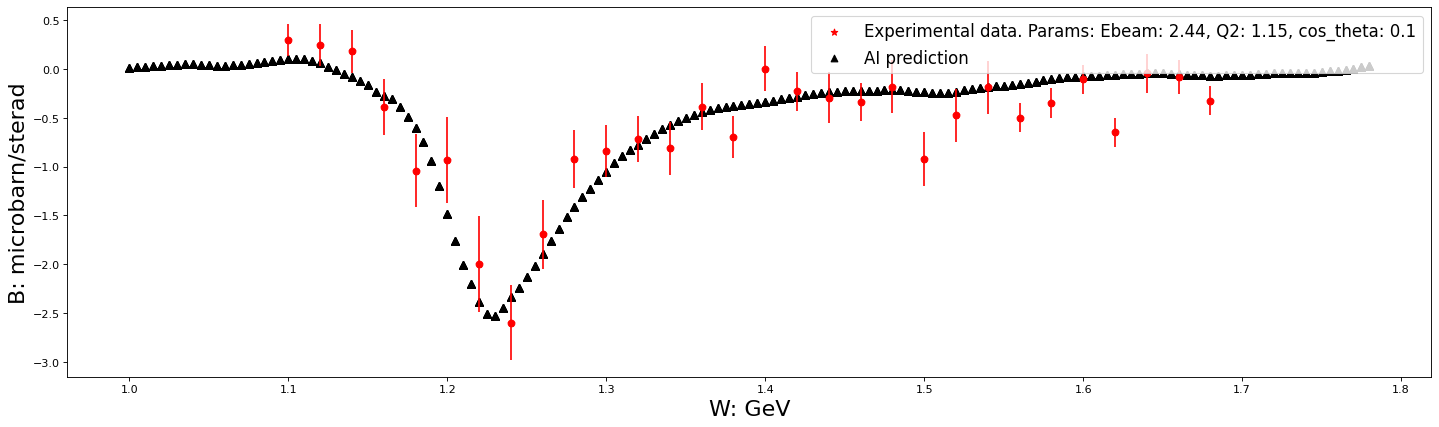

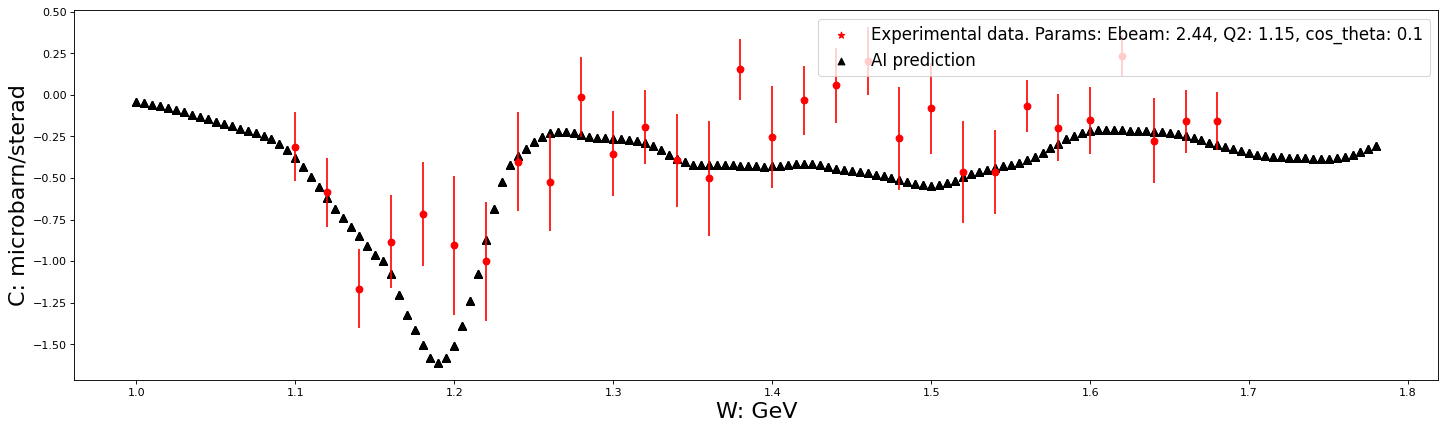

100%|██████████| 97/97 [00:10<00:00,  9.67it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1394555201879692' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01036445969432638' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

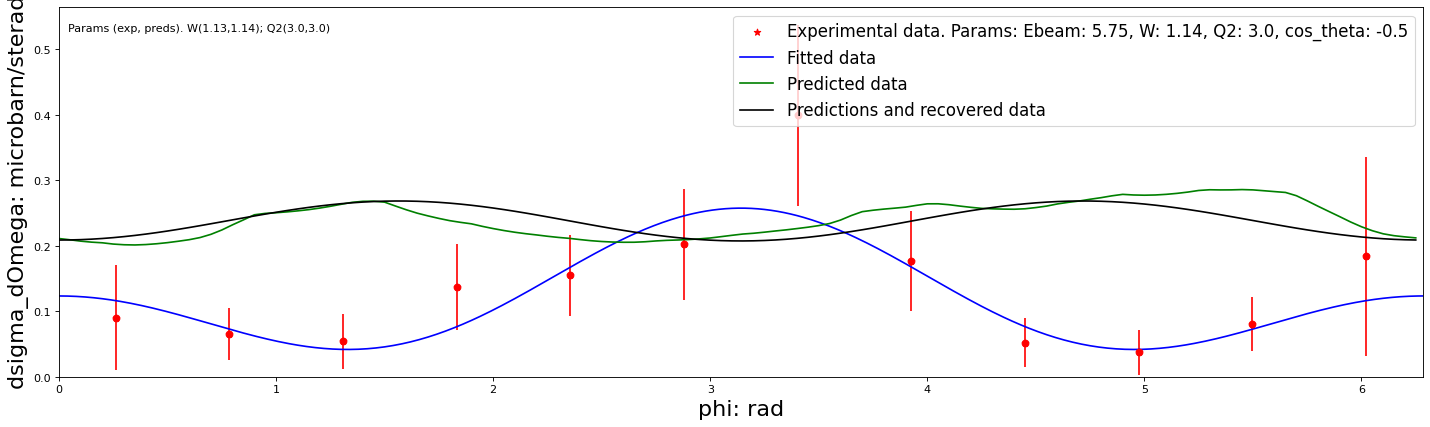

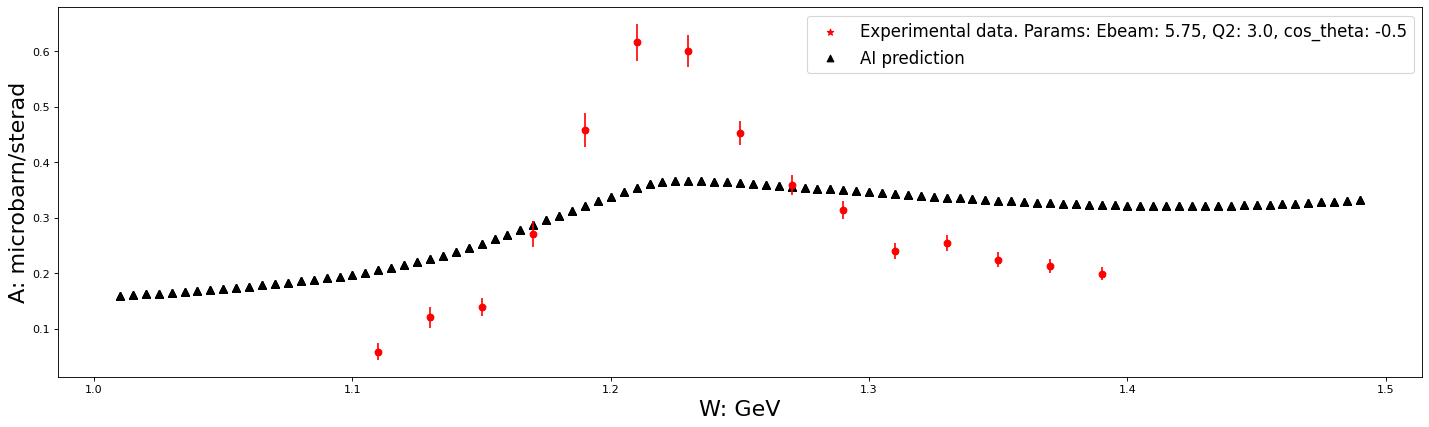

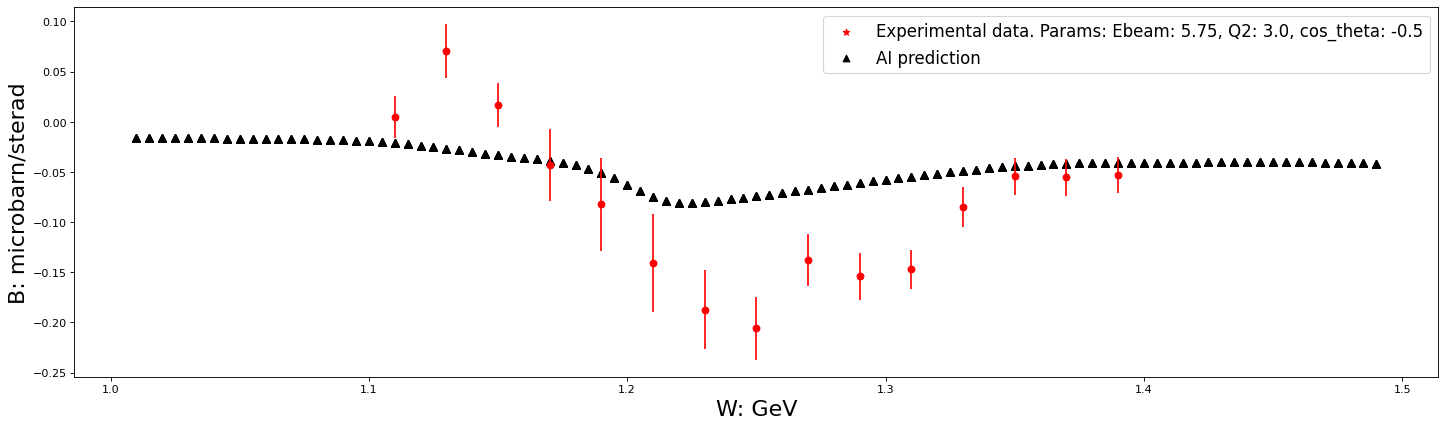

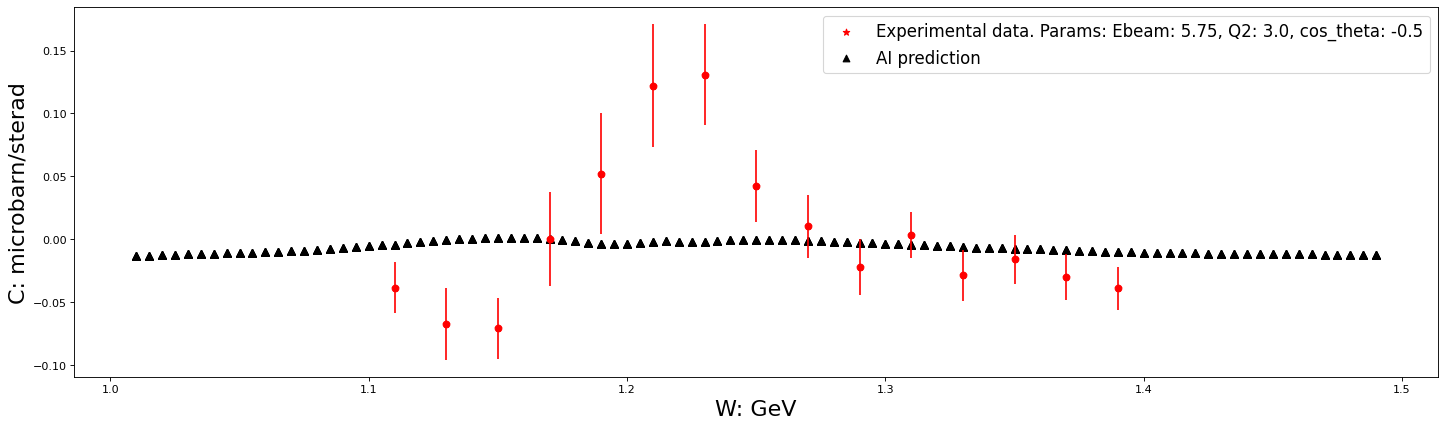

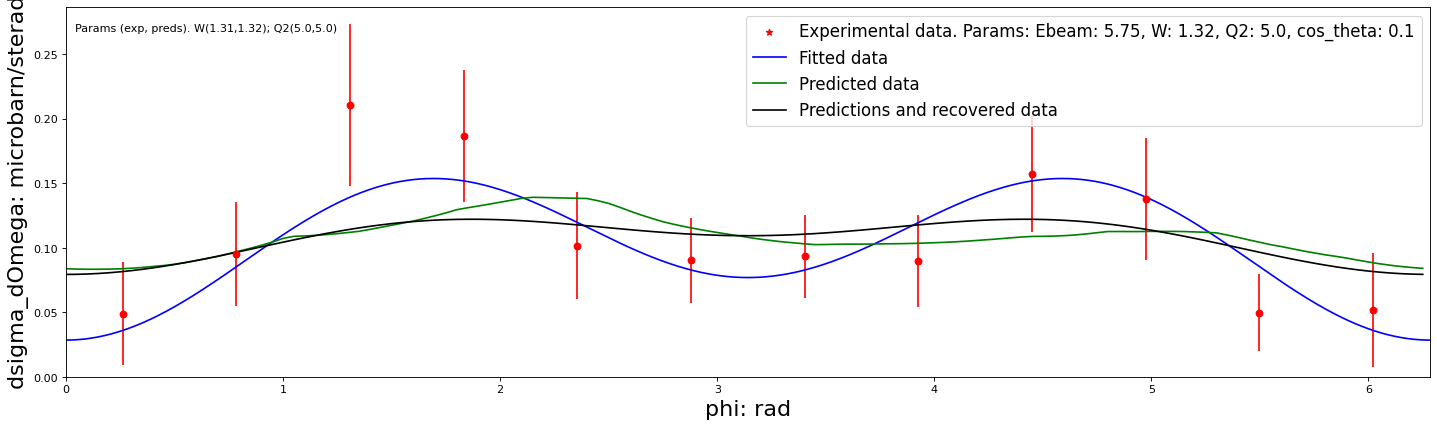

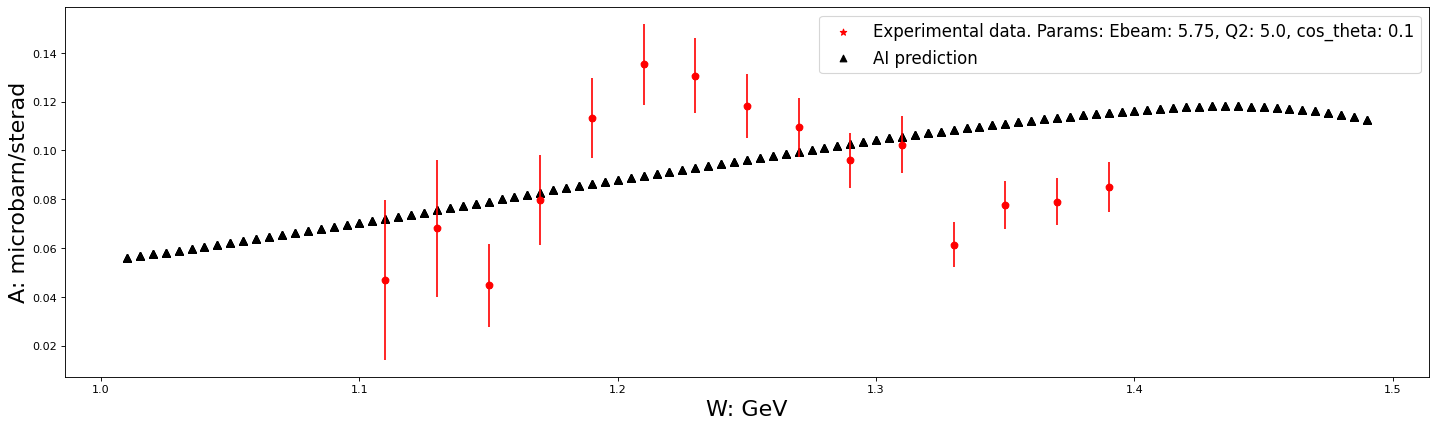

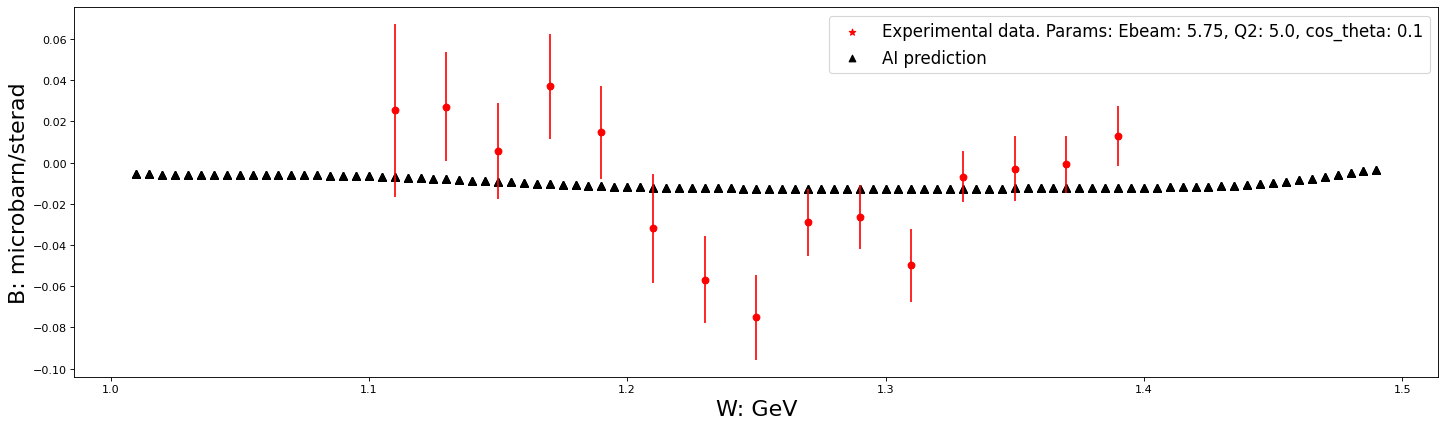

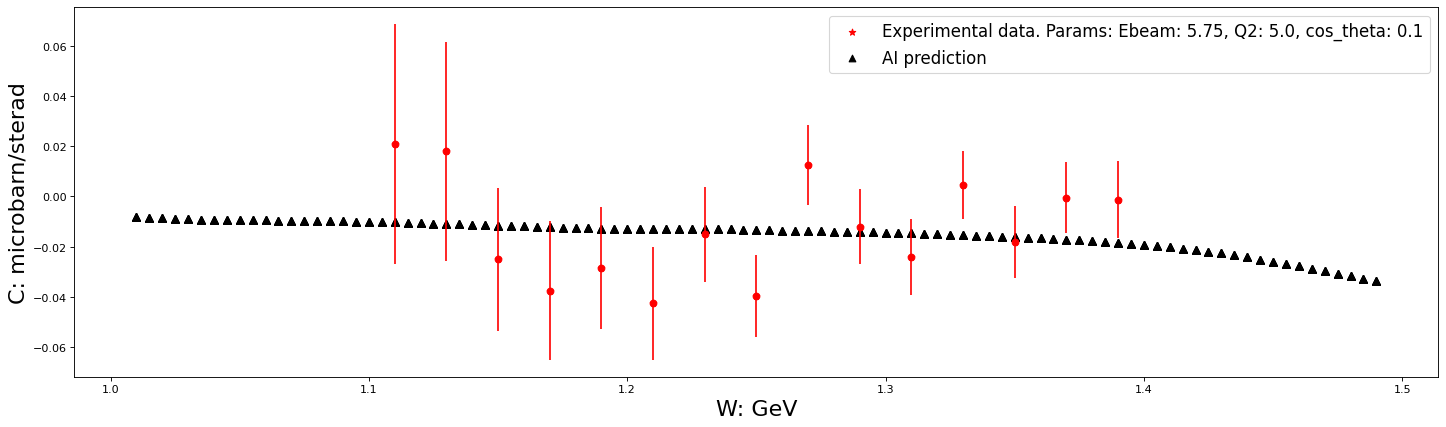

100%|██████████| 177/177 [00:06<00:00, 29.50it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-10-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.27703180868954785' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-10-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.015411971104513141' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

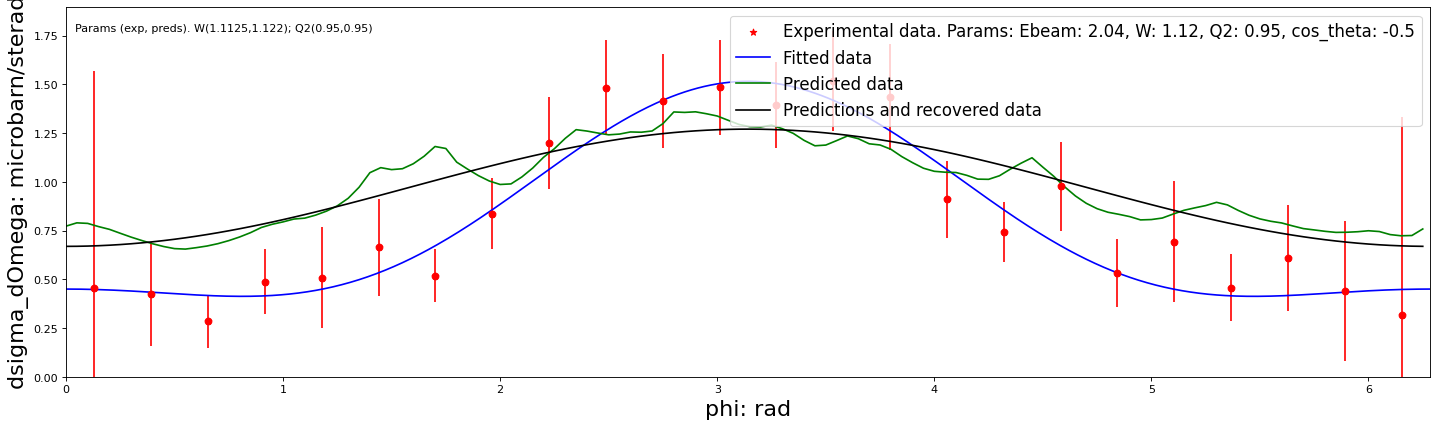

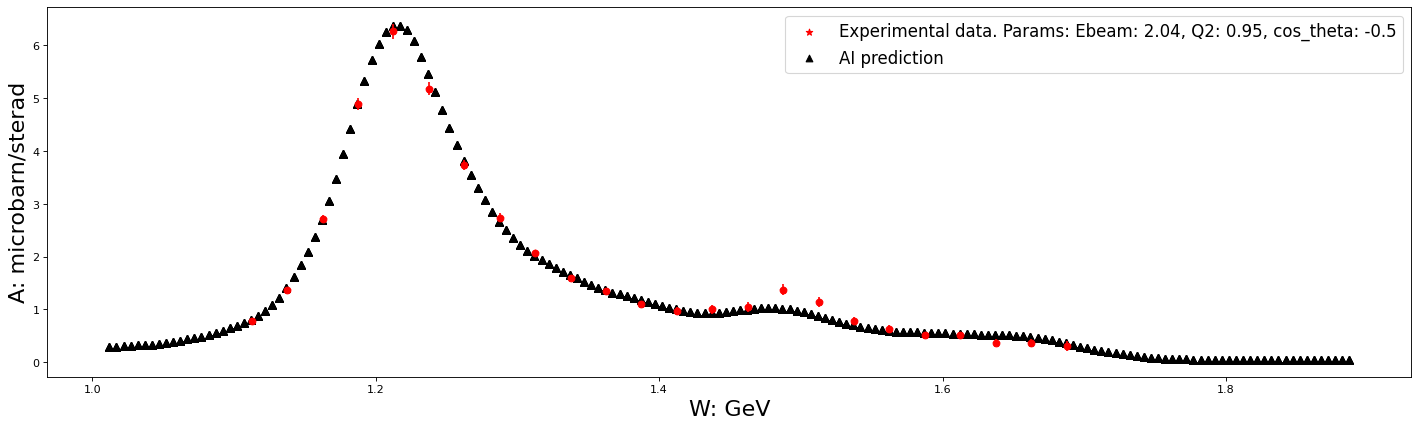

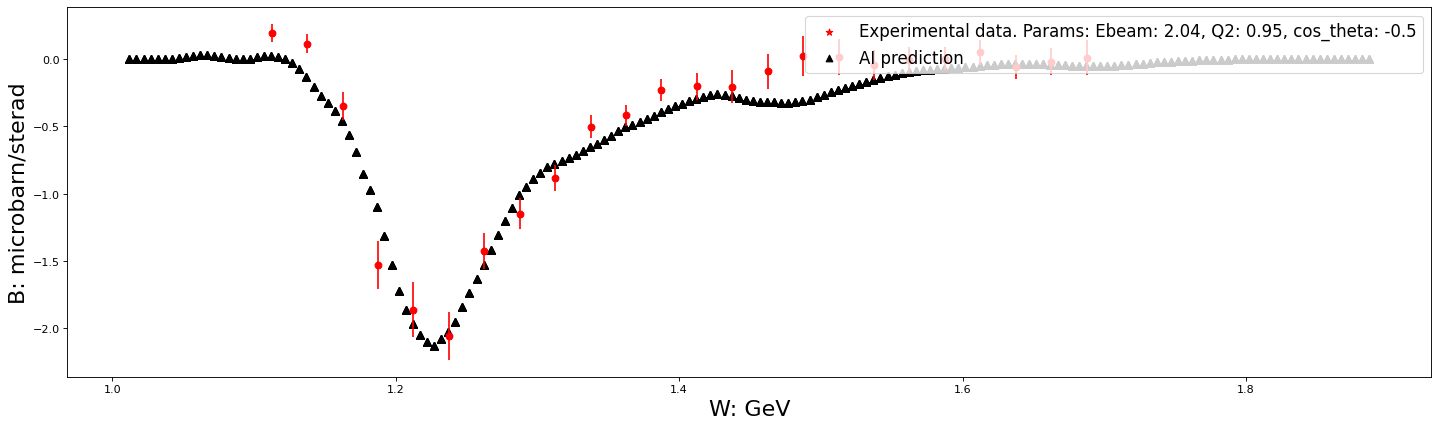

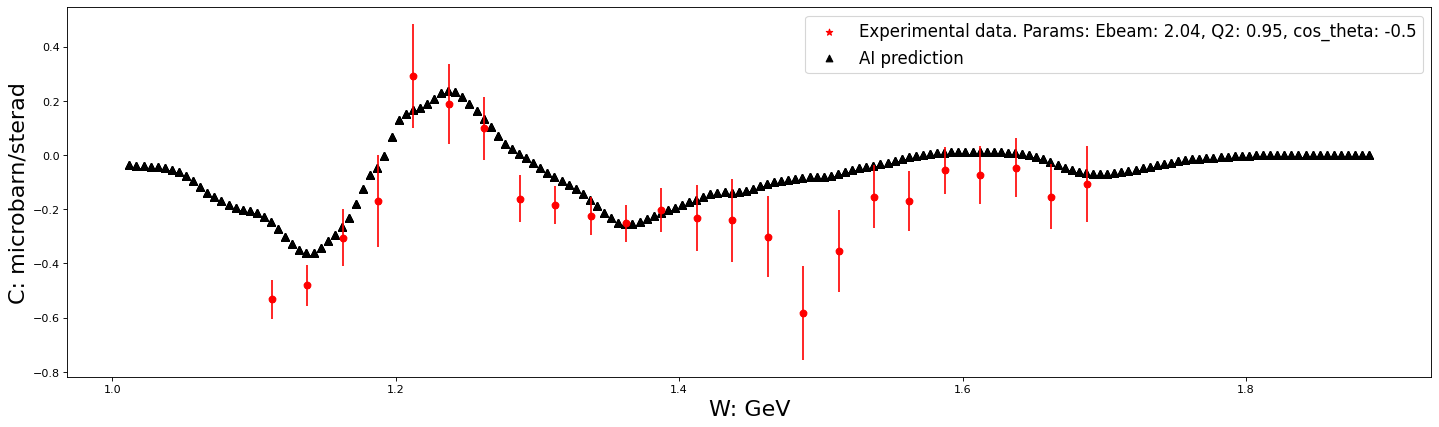

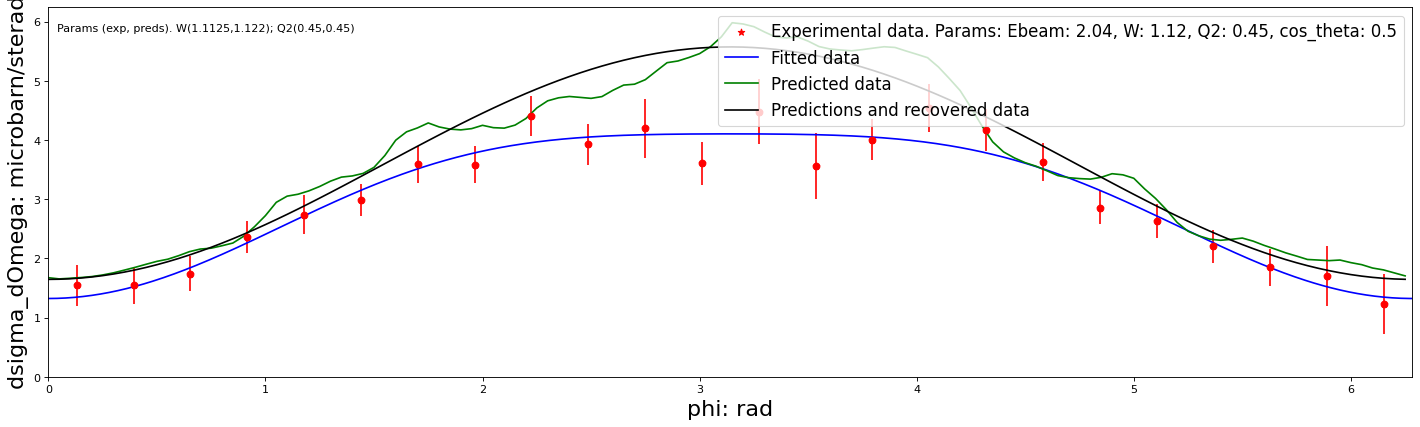

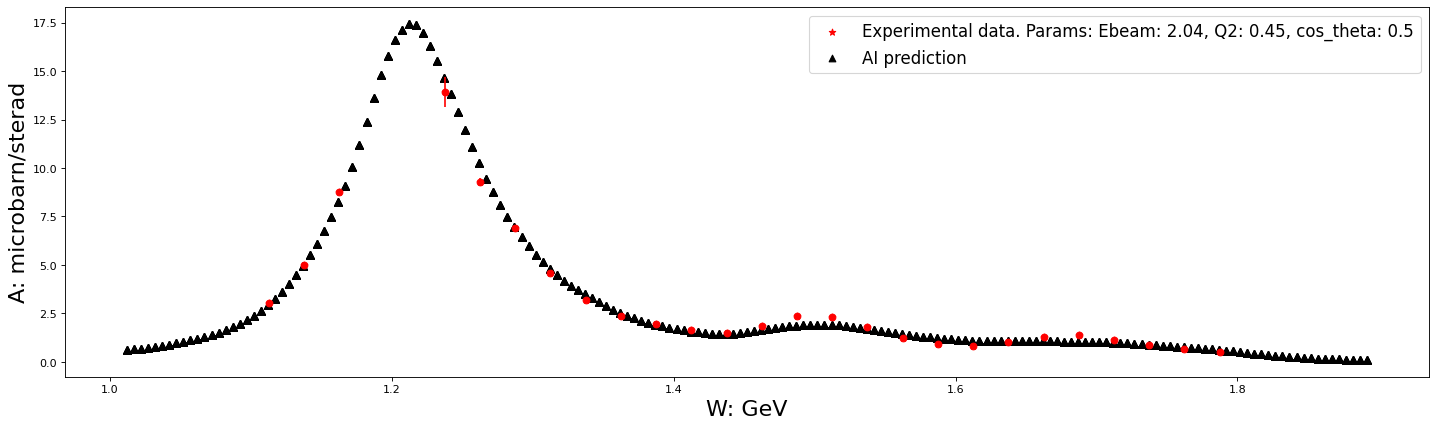

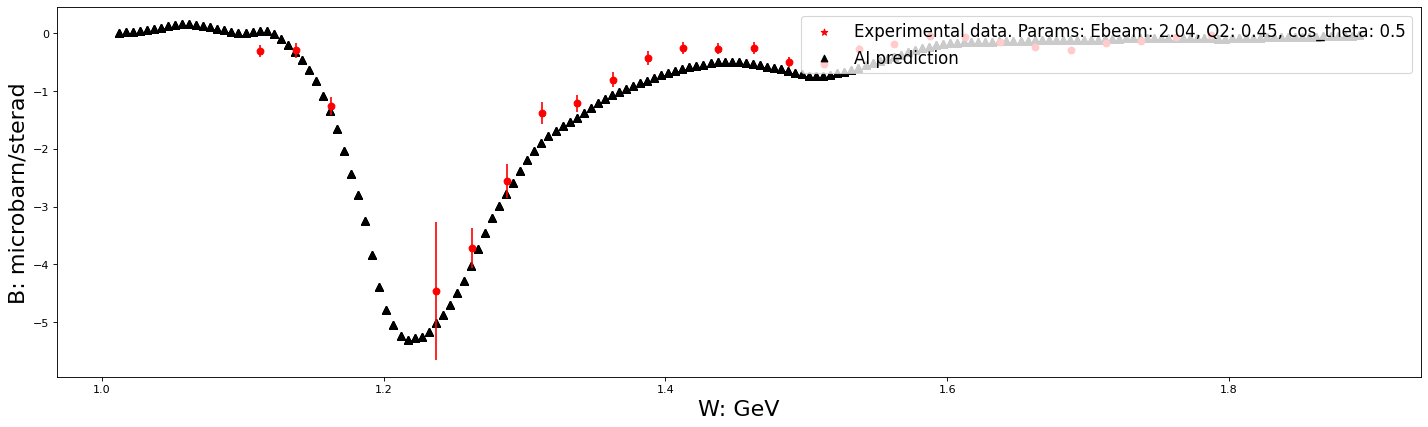

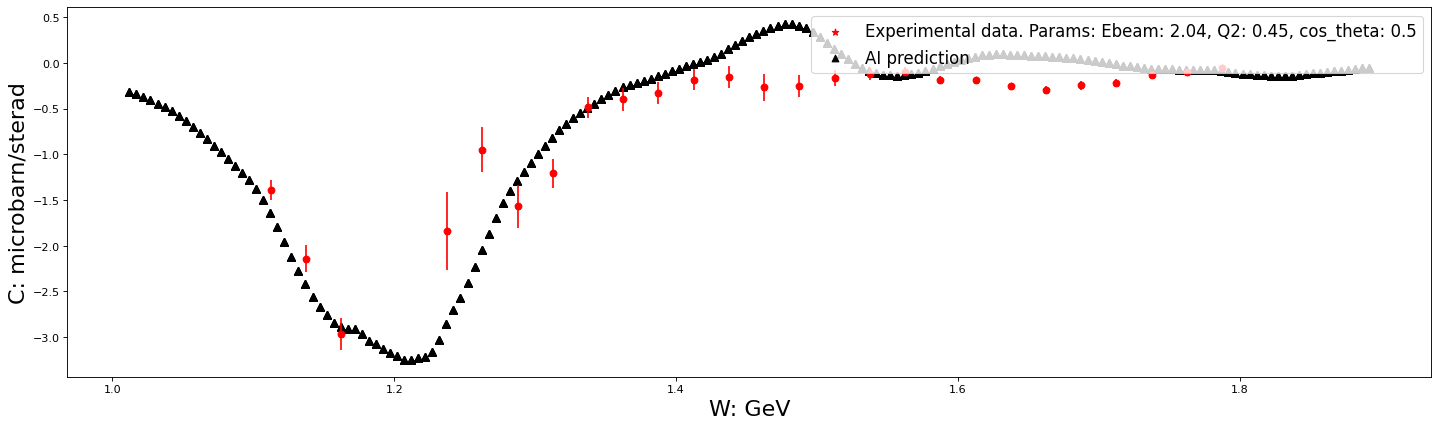

In [12]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [14]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2024-12-09 22:32:54,178 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:54,181 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:54,186 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:54,191 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-09 22:32:54,229 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-09 22:32:54,422 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-09 22:32:54,626 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-09 22:32:54,637 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:54,639 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:54,643 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:54,646 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-09 22:32:54,669 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:54,672 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:54,677 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:54,680 : DEBUG : STREAM b'IDAT' 131 38196
2024-12-09 22:32:54,706 : DEBUG : STREAM b'IHDR' 16 13
202

In [13]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-09 22:32:51,976 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:51,984 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:51,986 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:51,990 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-09 22:32:52,017 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:52,020 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:52,023 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:52,027 : DEBUG : STREAM b'IDAT' 131 38196
2024-12-09 22:32:52,045 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:52,048 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:52,052 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:52,055 : DEBUG : STREAM b'IDAT' 131 37168
2024-12-09 22:32:52,072 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:52,075 : DEBUG : STREAM b'tEXt' 41 57
2024-12-09 22:32:52,077 : DEBUG : STREAM b'pHYs' 110 9
2024-12-09 22:32:52,079 : DEBUG : STREAM b'IDAT' 131 36978
2024-12-09 22:32:52,097 : DEBUG : STREAM b'IHDR' 16 13
2024-12-09 22:32:52,100 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [15]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,██████▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▇▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▂▇▇▇▇██████████████████████████████████
train_rmse,█▇▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▆▅▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▄▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 157/157 [00:04<00:00, 33.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3846924947271446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006029384299421474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

2024-12-03 16:02:50,100 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-03 16:02:50,103 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-03 16:02:50,106 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-12-03 16:02:50,109 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-03 16:02:50,111 : DEBUG : findfont: sc

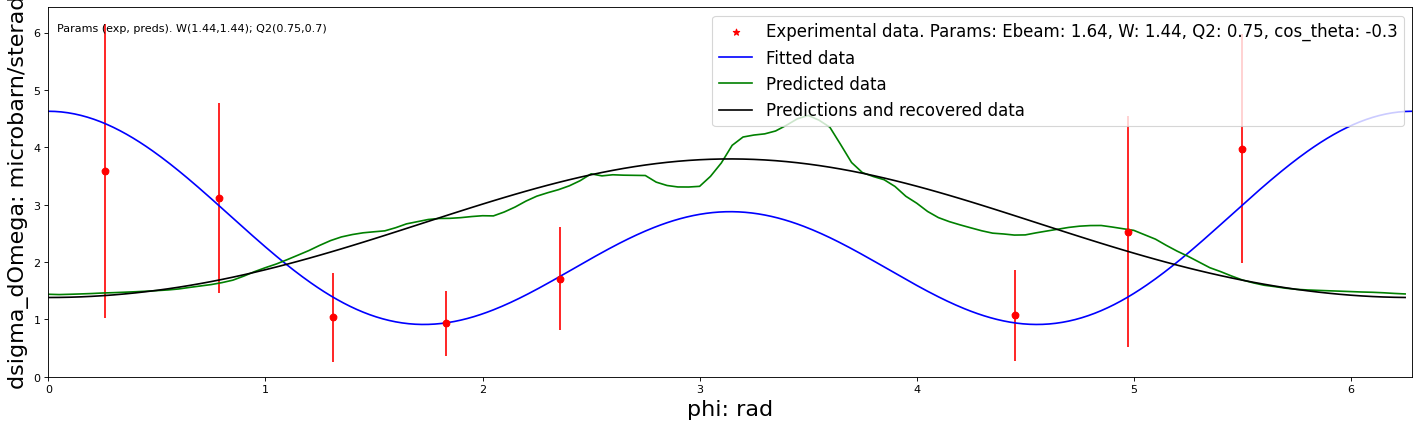

2024-12-03 16:02:52,649 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,651 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:52,653 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:52,655 : DEBUG : STREAM b'IDAT' 131 36433
2024-12-03 16:02:52,787 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,790 : DEBUG : STREAM b'IDAT' 41 36433


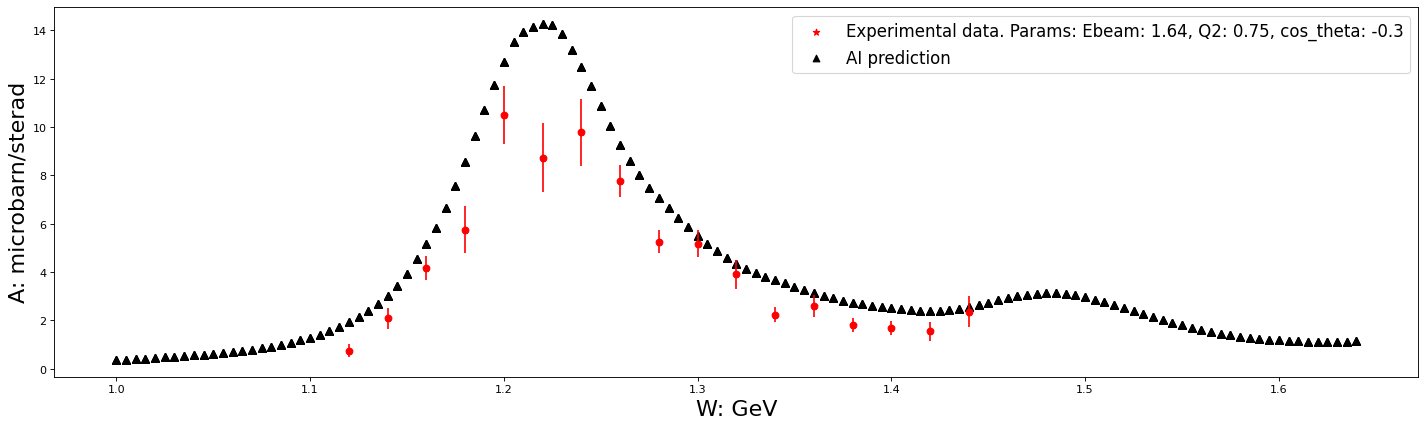

2024-12-03 16:02:53,850 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,852 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:53,854 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:53,856 : DEBUG : STREAM b'IDAT' 131 35982
2024-12-03 16:02:53,938 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,940 : DEBUG : STREAM b'IDAT' 41 35982


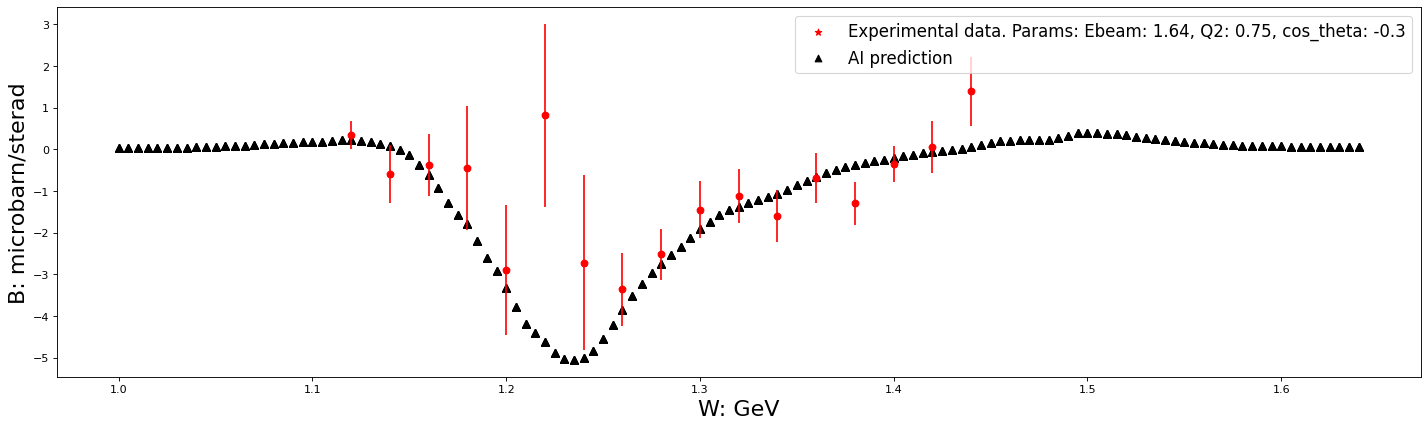

2024-12-03 16:02:54,613 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,615 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:54,617 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:54,620 : DEBUG : STREAM b'IDAT' 131 36865
2024-12-03 16:02:54,704 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,706 : DEBUG : STREAM b'IDAT' 41 36865


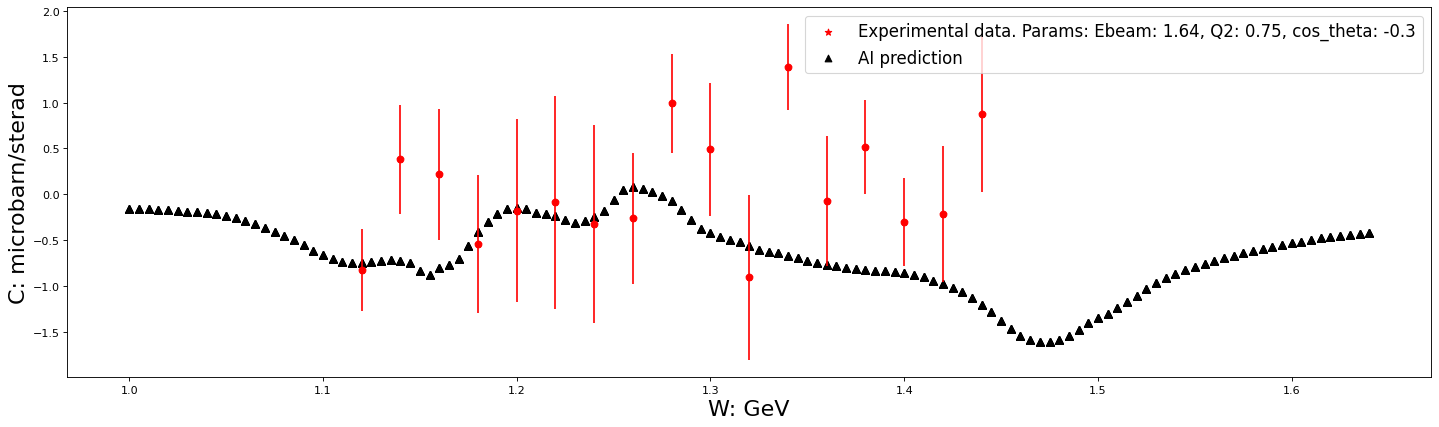

1
2024-12-03 16:02:55,385 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,387 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:55,390 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:55,394 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:02:55,485 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,488 : DEBUG : STREAM b'IDAT' 41 65536


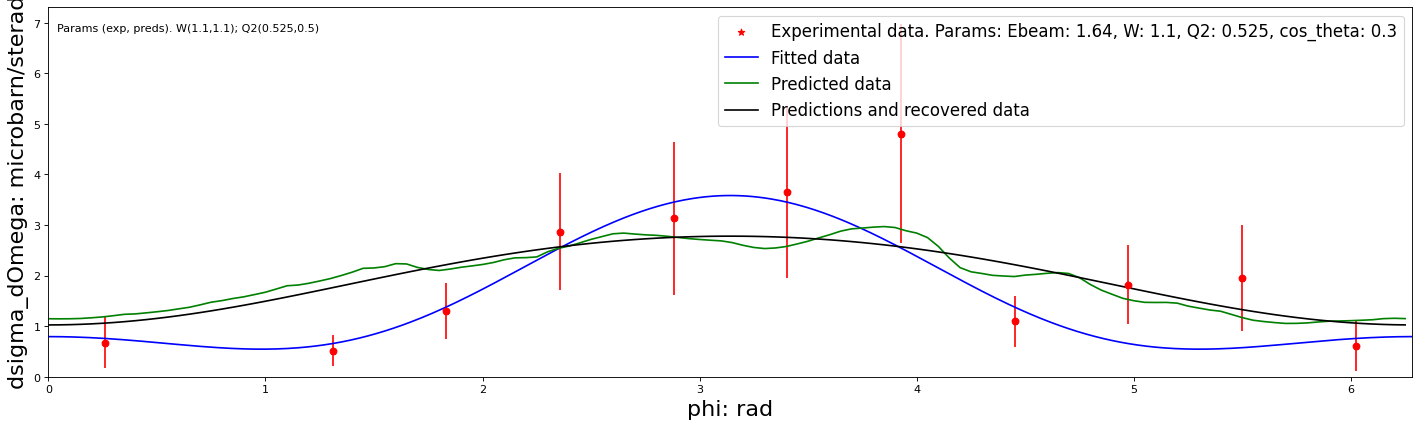

2024-12-03 16:02:56,183 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,185 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:56,191 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:56,195 : DEBUG : STREAM b'IDAT' 131 37516
2024-12-03 16:02:56,292 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,295 : DEBUG : STREAM b'IDAT' 41 37516


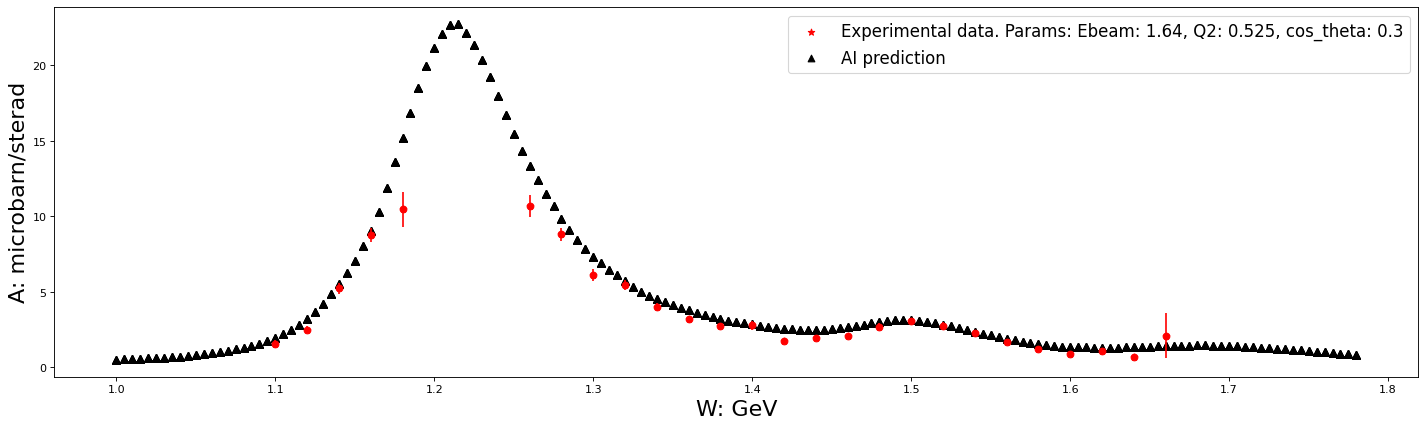

2024-12-03 16:02:56,996 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,998 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,000 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,002 : DEBUG : STREAM b'IDAT' 131 36214
2024-12-03 16:02:57,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,086 : DEBUG : STREAM b'IDAT' 41 36214


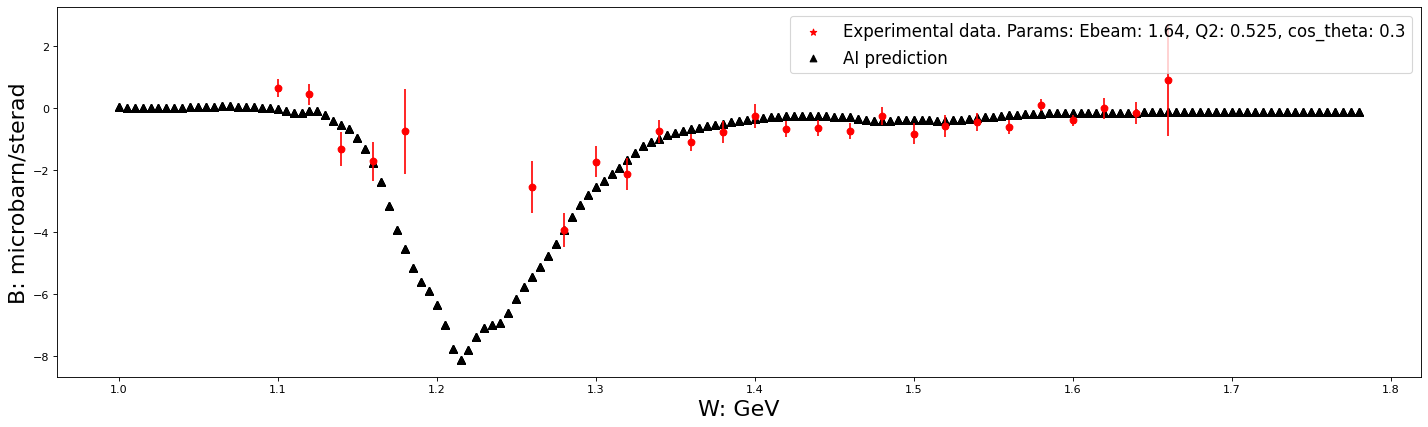

2024-12-03 16:02:57,790 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,792 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,795 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,798 : DEBUG : STREAM b'IDAT' 131 36991
2024-12-03 16:02:57,884 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,886 : DEBUG : STREAM b'IDAT' 41 36991


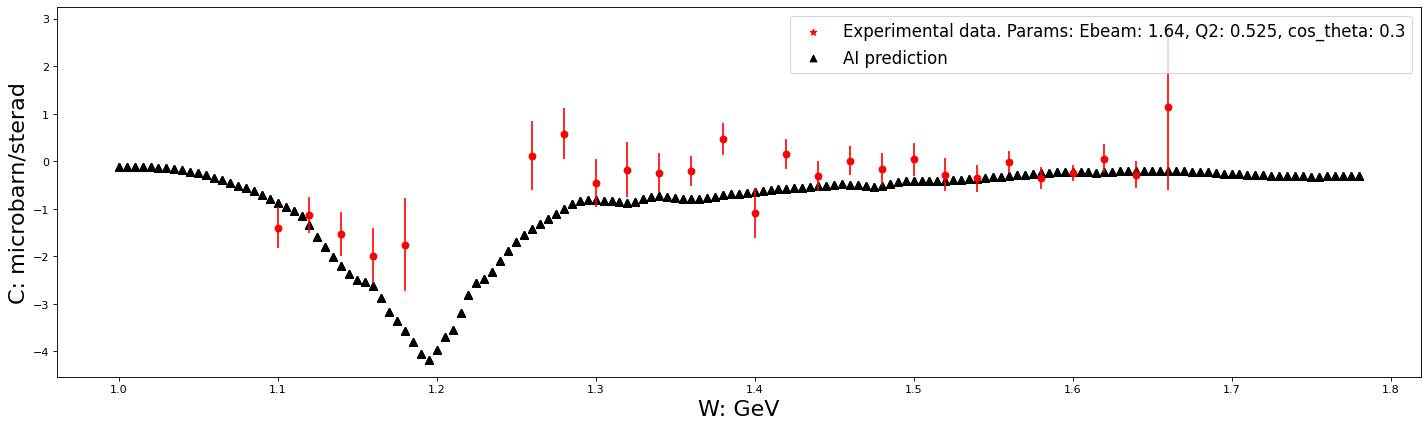

2


100%|██████████| 157/157 [00:07<00:00, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3759944385466103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06444017856602151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-

2024-12-03 16:17:39,521 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:39,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:39,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:39,644 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,647 : DEBUG : STREAM b'IDAT' 41 65536


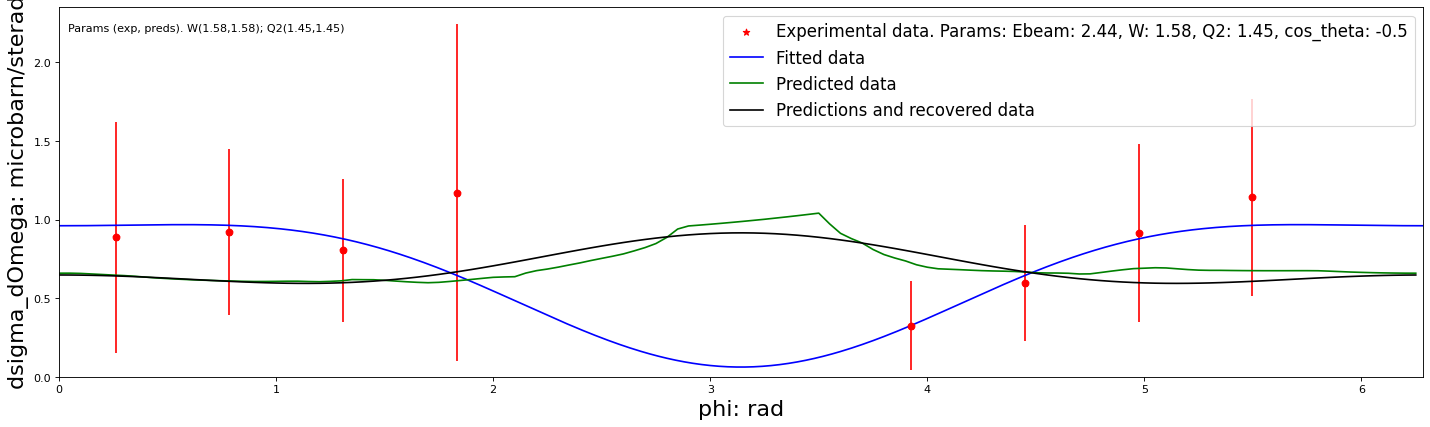

2024-12-03 16:17:40,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,533 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:40,535 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:40,537 : DEBUG : STREAM b'IDAT' 131 39649
2024-12-03 16:17:40,633 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,636 : DEBUG : STREAM b'IDAT' 41 39649


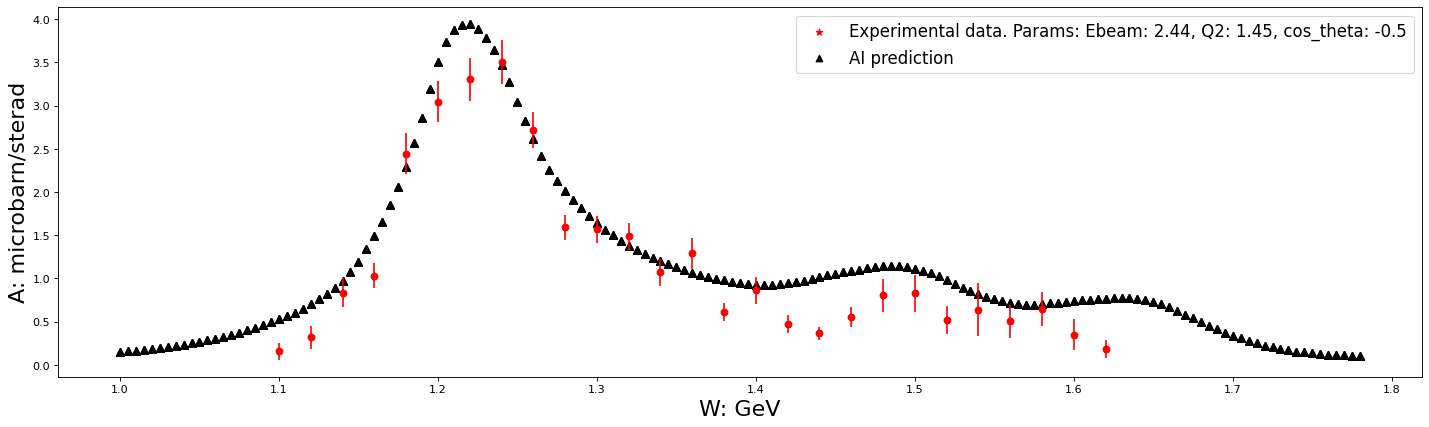

2024-12-03 16:17:41,532 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,534 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:41,537 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:41,539 : DEBUG : STREAM b'IDAT' 131 39774
2024-12-03 16:17:41,635 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,641 : DEBUG : STREAM b'IDAT' 41 39774


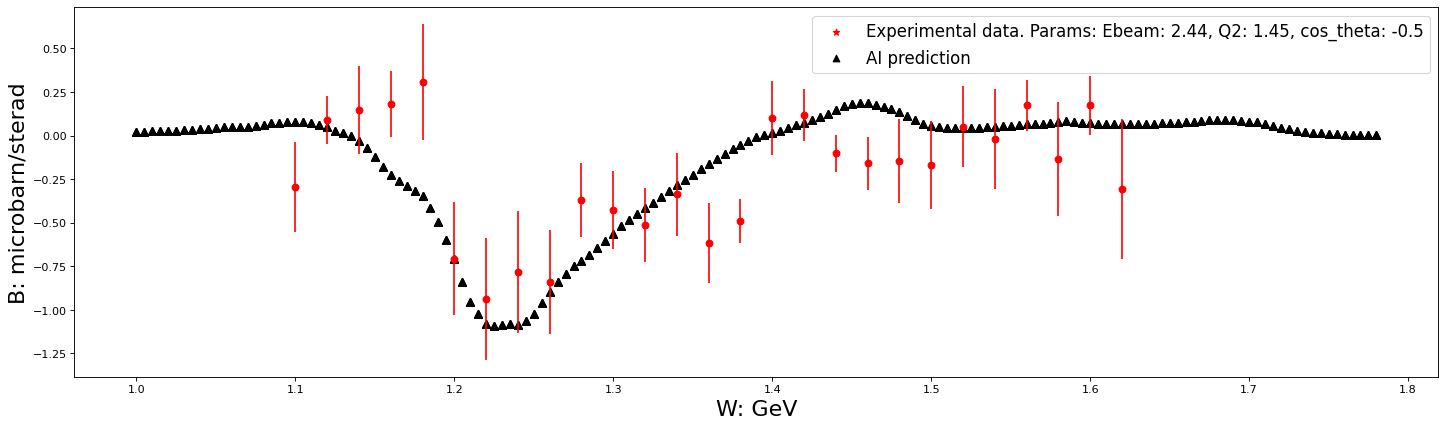

2024-12-03 16:17:42,570 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,574 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:42,576 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:42,579 : DEBUG : STREAM b'IDAT' 131 40327
2024-12-03 16:17:42,675 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,677 : DEBUG : STREAM b'IDAT' 41 40327


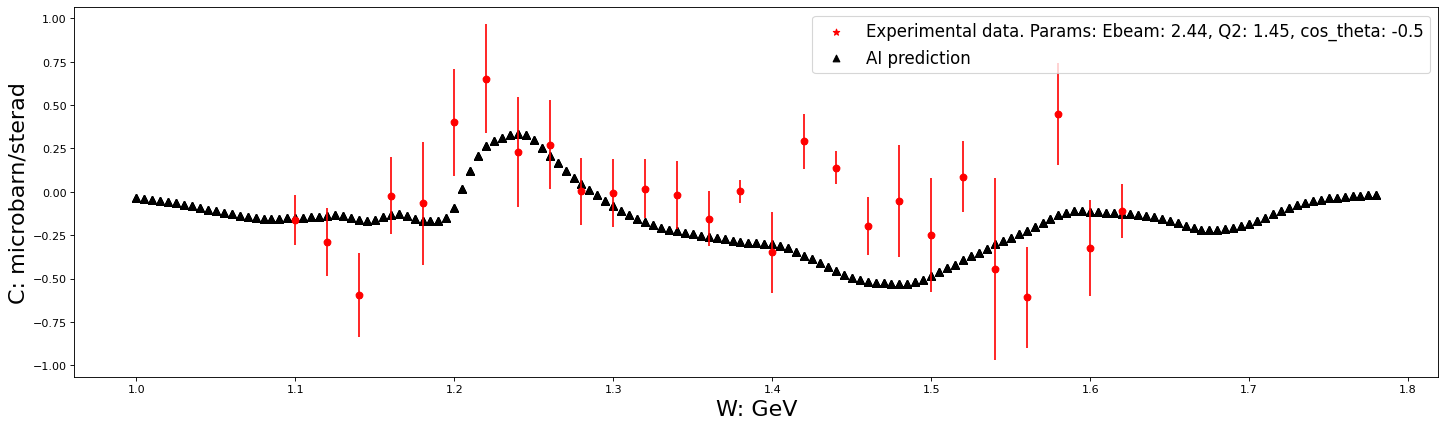

1
2024-12-03 16:17:43,580 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,582 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:43,585 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:43,588 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:43,687 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,692 : DEBUG : STREAM b'IDAT' 41 65536


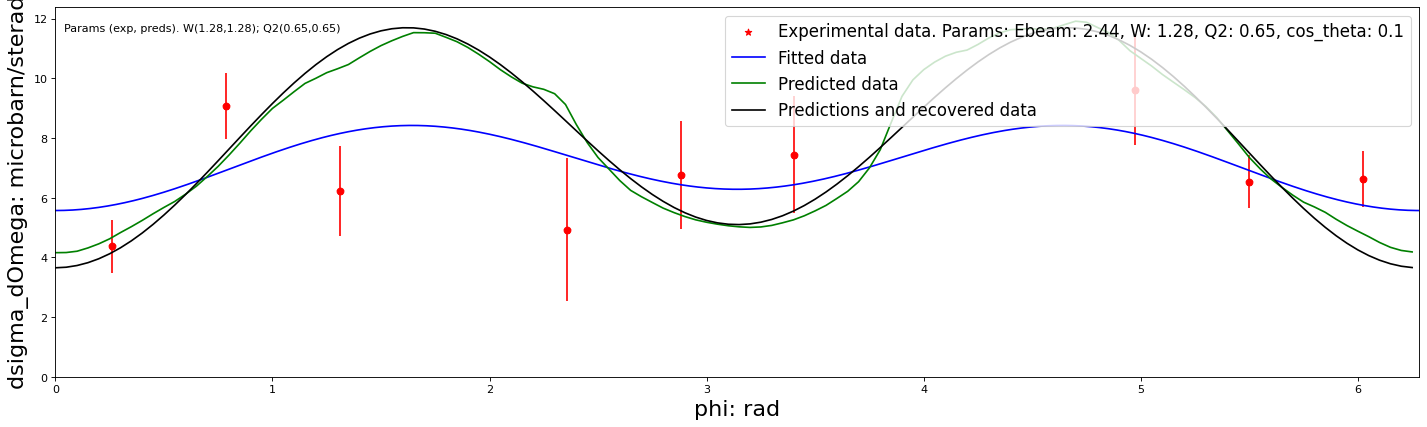

2024-12-03 16:17:44,586 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,589 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:44,591 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:44,594 : DEBUG : STREAM b'IDAT' 131 39500
2024-12-03 16:17:44,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,693 : DEBUG : STREAM b'IDAT' 41 39500


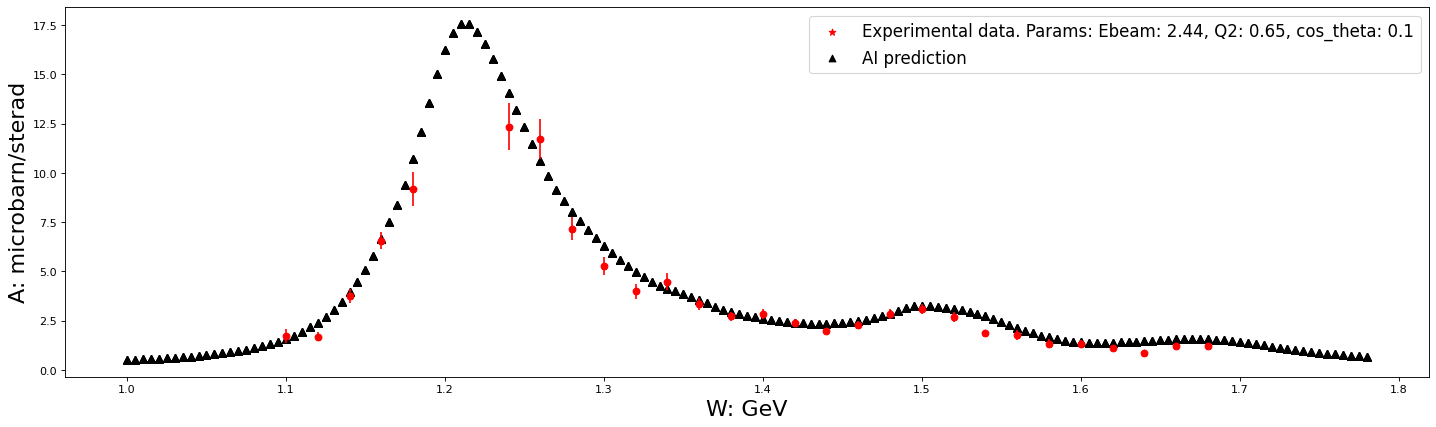

2024-12-03 16:17:45,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:45,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:45,599 : DEBUG : STREAM b'IDAT' 131 36530
2024-12-03 16:17:45,692 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,694 : DEBUG : STREAM b'IDAT' 41 36530


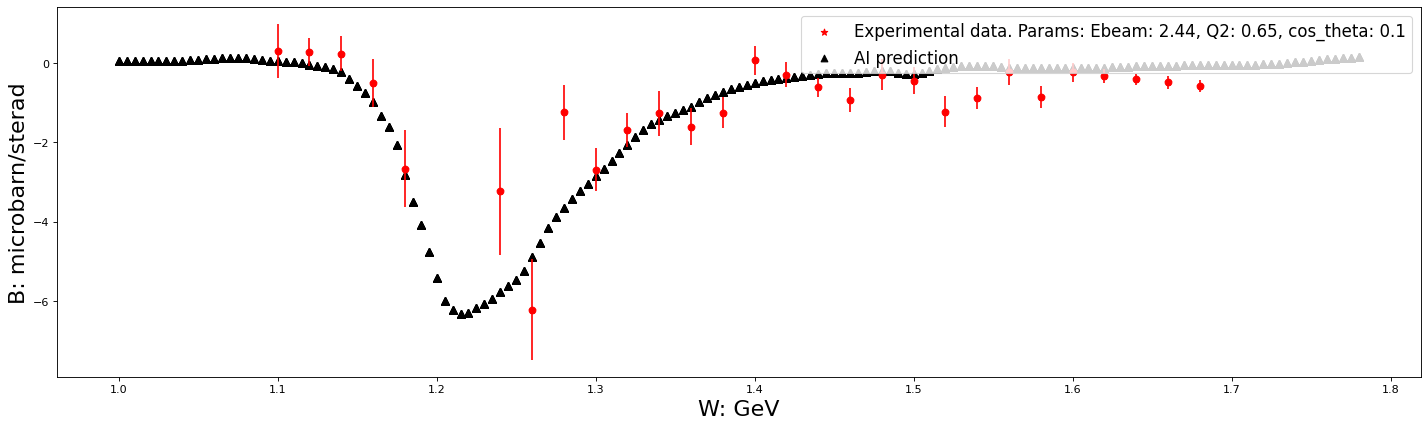

2024-12-03 16:17:46,823 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,828 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:46,830 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:46,833 : DEBUG : STREAM b'IDAT' 131 39694
2024-12-03 16:17:46,983 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,988 : DEBUG : STREAM b'IDAT' 41 39694


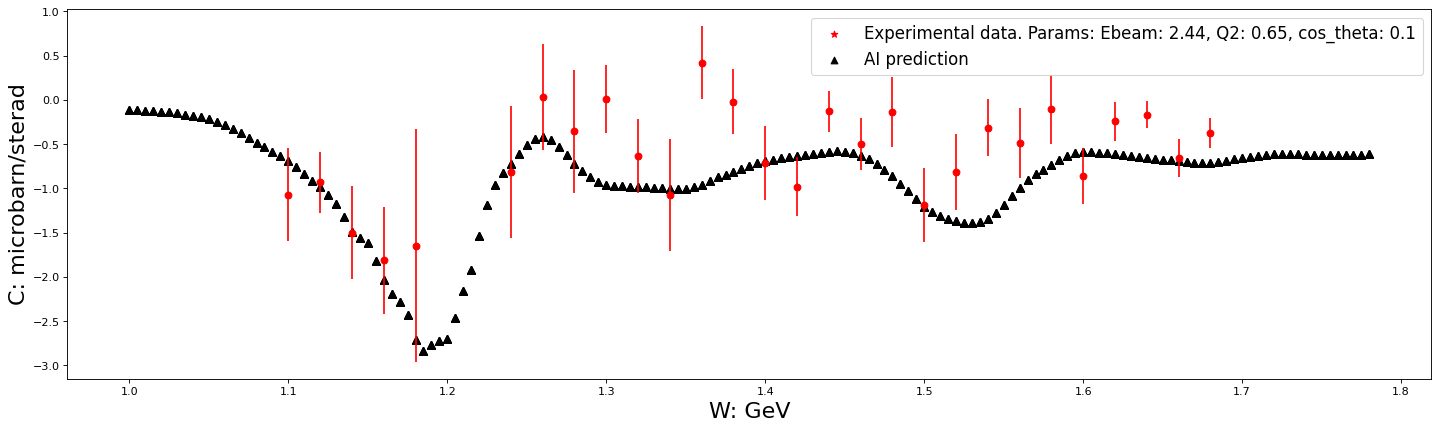

2


100%|██████████| 97/97 [00:09<00:00, 10.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 24%|██▍       | 24/100 [04:08<13:07, 10.36s/it]


KeyboardInterrupt: 

In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False